In [1]:
!pip install category_encoders
!pip install seaborn
!pip install scikit-learn
!!pip install matplotlib
!pip install numpy
!pip install dython

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import scipy.stats as ss
from dython.model_utils import roc_graph
from dython.nominal import associations
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, classification_report, log_loss, mean_squared_error
from sklearn.model_selection import learning_curve

In [2]:
import pathlib
pathlib.Path().absolute()
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [3]:
df = pd.read_csv(r'Kaggle_Salary.csv', low_memory=False)

### Data Cleaning

We start by identifying the NaN values and getting rid of them wherever possible. 

In [4]:
df.isna().sum()

Time from Start to Finish (seconds)        0
Q1                                         0
Q2                                         0
Q2_OTHER_TEXT                              0
Q3                                         0
Q4                                         0
Q5                                         0
Q5_OTHER_TEXT                              0
Q6                                         0
Q7                                         0
Q8                                         0
Q9_Part_1                               6518
Q9_Part_2                               8990
Q9_Part_3                               7607
Q9_Part_4                               9212
Q9_Part_5                               8863
Q9_Part_6                              10194
Q9_Part_7                              11982
Q9_Part_8                              12258
Q9_OTHER_TEXT                              0
Q10                                        0
Q11                                      247
Q12_Part_1

In [5]:
df['Q11'].value_counts(dropna = False)

$0 (USD)             4038
$100-$999            2335
$1000-$9,999         2123
$1-$99               1485
$10,000-$99,999      1268
> $100,000 ($USD)    1001
NaN                   247
Name: Q11, dtype: int64

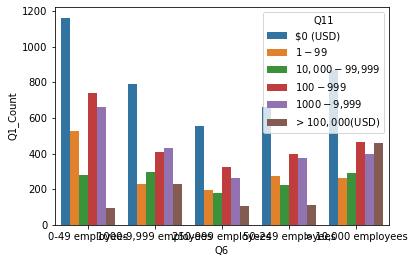

In [6]:
# Constructing a bar plot to visualize ML spend vs size of company 
small_df = pd.DataFrame()
small_df['Q6'] = df['Q6']
small_df['Q11'] = df['Q11']
small_df['Q1'] = df['Q1']

g1 = small_df.groupby(['Q6','Q11']).count()

agg = g1.add_suffix('_Count').reset_index()

sns.barplot(x = 'Q6', y = 'Q1_Count', hue = 'Q11', data = agg)

This graph shows that regardless of the size of company, 0 USD is the most frequent occurence with respect to Machine Learning Spend. Therefore, it makes sense to impute NaN values as zero with respect to Q11.



In [7]:
#IMPUTING NaN TO MOST FREQUENT VALUE: Change ML spend NaN values to mode,ie, 0 USD
df['Q11'] = df['Q11'].fillna(df['Q11'].mode()[0])
df[df['Q11'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


In [8]:
df['Q14'].value_counts(dropna = False)

Local development environments (RStudio, JupyterLab, etc.)              5925
Basic statistical software (Microsoft Excel, Google Sheets, etc.)       2094
NaN                                                                     1045
Cloud-based data software & APIs (AWS, GCP, Azure, etc.)                1033
Other                                                                    871
Business intelligence software (Salesforce, Tableau, Spotfire, etc.)     787
Advanced statistical software (SPSS, SAS, etc.)                          742
Name: Q14, dtype: int64

In [9]:
#Imputing NaN to "Other" since we cannot deduce what 1045 respondents have answered
df['Q14'] = df['Q14'].fillna("Other")
df[df['Q14'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


In [10]:
df['Q15'].value_counts(dropna = False)

3-5 years                    2818
1-2 years                    2713
< 1 years                    2049
5-10 years                   1749
NaN                          1075
10-20 years                  1004
I have never written code     552
20+ years                     537
Name: Q15, dtype: int64

In [11]:
# Imputing NaNs in Q15 with those who have never written code since it is more likely that people
# who don't have any coding experience would likely not answer this question
df['Q15'] = df['Q15'].fillna("I have never written code")
df[df['Q15'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


In [12]:
df['Q22'].value_counts(dropna = False)

Never         8512
NaN           1947
Once           976
2-5 times      795
6-24 times     145
> 25 times     122
Name: Q22, dtype: int64

In [13]:
#IMPUTING NaN for Q22 TO MOST FREQUENT VALUE: Never
df['Q22'] = df['Q22'].fillna(df['Q22'].mode()[0])
df[df['Q22'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


In [14]:
df['Q23'].value_counts(dropna = False)

< 1 years      3068
1-2 years      2727
NaN            1956
2-3 years      1569
3-4 years       975
4-5 years       863
5-10 years      833
10-15 years     330
20+ years       176
Name: Q23, dtype: int64

In [15]:
#Makes sense to impute NaN with the lowest possible experience class of < 1 years, which also happens to be mode
df['Q23'] = df['Q23'].fillna(df['Q23'].mode()[0])
df[df['Q23'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


In [16]:
df['Q19'].value_counts(dropna = False) 

Python        8200
NaN           1844
R             1073
SQL            736
C++            128
MATLAB         115
Other          113
C               84
Java            70
None            61
Javascript      37
Bash            31
TypeScript       5
Name: Q19, dtype: int64

In [17]:
#Imputing Nan values with "Python" since it is the mode
df['Q19'] = df['Q19'].fillna('Python')
df[df['Q19'].isnull()]

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q12_Part_1,Q12_Part_2,Q12_Part_3,Q12_Part_4,Q12_Part_5,Q12_Part_6,Q12_Part_7,Q12_Part_8,Q12_Part_9,Q12_Part_10,Q12_Part_11,Q12_Part_12,Q12_OTHER_TEXT,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q19,Q19_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q22,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q28_Part_1,Q28_Part_2,Q28_Part_3,Q28_Part_4,Q28_Part_5,Q28_Part_6,Q28_Part_7,Q28_Part_8,Q28_Part_9,Q28_Part_10,Q28_Part_11,Q28_Part_12,Q28_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q30_Part_1,Q30_Part_2,Q30_Part_3,Q30_Part_4,Q30_Part_5,Q30_Part_6,Q30_Part_7,Q30_Part_8,Q30_Part_9,Q30_Part_10,Q30_Part_11,Q30_Part_12,Q30_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets


### Dropping Unnecessary Columns
We need to drop columns that are not essential to the logistic regression model to reduce feature complexity.

In [18]:
#We can drop columns related to Q12 (facourite media sources fro data science) since this will likely not determine the response (salary)
df.drop(columns = ['Q12_Part_1','Q12_Part_2','Q12_Part_3','Q12_Part_4','Q12_Part_5','Q12_Part_6','Q12_Part_7','Q12_Part_8','Q12_Part_9','Q12_Part_10','Q12_Part_11','Q12_Part_12','Q12_OTHER_TEXT'], inplace = True)

#We can drop columns related to Q19 since their recommendation for budding data scientists is likely not going to influence response
df.drop(columns = ['Q19','Q19_OTHER_TEXT'], inplace = True)

#Q22 regarding TPUs is rather redundant since the previous question gives a fair idea of TPU usage. So we drop. 
df.drop(columns = ['Q22'], inplace = True)

#Q28 regarding ML frameworks is also rather redundant due to the presence of Q24, Q25 & Q32 that point towards ML tools. Also, this seems largely skewed towards scikit learn & tensorflow
df.drop(columns = ['Q28_Part_1','Q28_Part_2','Q28_Part_3','Q28_Part_4','Q28_Part_5','Q28_Part_6','Q28_Part_7','Q28_Part_8','Q28_Part_9','Q28_Part_10','Q28_Part_11','Q28_Part_12','Q28_OTHER_TEXT'], inplace = True)

#Q30 regarding cloud computing products is an ancillary to Q29 that deals with cloud computing platforms which we are more interested in for our analysis. So, we drop. 
df.drop(columns = ['Q30_Part_1','Q30_Part_2','Q30_Part_3','Q30_Part_4','Q30_Part_5','Q30_Part_6','Q30_Part_7','Q30_Part_8','Q30_Part_9','Q30_Part_10','Q30_Part_11','Q30_Part_12','Q30_OTHER_TEXT'], inplace = True)


In [19]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_OTHER_TEXT,Q10,Q11,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,"30,000-39,999",$0 (USD),NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,NaN,NaN,-1,"Basic statistical software (Microsoft Excel, G...",0,-1,-1,-1,-1,-1,1-2 years,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,PyCharm,NaN,MATLAB,NaN,Spyder,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,-1,NaN,Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,CPUs,GPUs,NaN,NaN,NaN,-1,1-2 years,Linear or Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999"
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...",Analyze and understand data to influence produ...,Build and/or run the data infrastructure that ...,Build prototypes to explore applying machine l...,Build and/or run a machine learning service th...,NaN,NaN,NaN,NaN,-1,"5,000-7,499","> $100,000 ($USD)",NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,NaN,NaN,-1,"Cloud-based data software & APIs (AWS, GCP, Az...",-1,-1,-1,-1,0,-1,I have never written code,

### Encoding Features
Depending on the feature, we choose either a one-hot encoding/label encoding or min-max normalization encoding strategy.

In [20]:
# Writing a function to go through particular columns relating to a question, and
# this function will encode NaN responses as zero & text responses as one after taking Question no & number of responses as input 

def column_encode(Q_no, Parts):
    #construct list of column names 
    col_list = []
    for i in range(Parts):
        col_list.append('Q%d_Part_%d' %(Q_no,i+1))

    #loop through columns, create duplicate columns, make NaNs zero & text as 1 in a new column
    for col in col_list:
        col_series = df[col]
        col_vals = col_series.values
        encodeList = []
        for val in col_vals:
            if(pd.isnull(val)):
                encodeList.append(0)
            else:
                encodeList.append(1)
    
        #Create dup;icate columns
        df[col+'_dummy'] = np.array(encodeList)
    
        #Drop the old column
        df.drop(columns = [col], inplace = True)
    
        #Rename the dummy column 
        df.rename(columns = {col+'_dummy':col}, inplace = True)
    
    #Drop the other text column since no actionable information can extracted. 
    df.drop(columns = ['Q%d_OTHER_TEXT' %Q_no], inplace = True)

In [21]:
#Encoding Q9 with 8 responses: Key activities that are part of role as data scientist
column_encode(9,8)

In [23]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q10,Q11,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q13_OTHER_TEXT,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q16_OTHER_TEXT,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q17_OTHER_TEXT,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q18_OTHER_TEXT,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q20_OTHER_TEXT,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q21_OTHER_TEXT,Q23,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q24_OTHER_TEXT,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q25_OTHER_TEXT,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q26_OTHER_TEXT,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q27_OTHER_TEXT,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q29_OTHER_TEXT,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q31_OTHER_TEXT,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q32_OTHER_TEXT,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q33_OTHER_TEXT,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q34_OTHER_TEXT,Q10_Encoded,Q10_buckets,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,NaN,NaN,-1,"Basic statistical software (Microsoft Excel, G...",0,-1,-1,-1,-1,-1,1-2 years,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,PyCharm,NaN,MATLAB,NaN,Spyder,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,Python,R,SQL,NaN,NaN,Java,Javascript,NaN,NaN,MATLAB,NaN,NaN,-1,NaN,Matplotlib,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,CPUs,GPUs,NaN,NaN,NaN,-1,1-2 years,Linear or Logistic Regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,3,"30,000-39,999",0,0,0,0,0,0,0,0
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)",NaN,Coursera,NaN,DataCamp,NaN,Kaggle Courses (i.e. Kaggle Learn),NaN,Udemy,NaN,NaN,NaN,NaN,-1,"Cloud-based data software & APIs (AWS, GCP, Az...",-1,-1,-1,-1,0,-1,I have never written code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,-1,< 1 years,NaN,NaN,NaN,NaN

In [22]:
#Encoding Q13 with 12 responses: Platforms for data science courses
column_encode(13,12)

#Encoding Q16 with 12 responses: Integrated Development Environments
column_encode(16,12)

#Encoding Q17 with 12 responses: Hosted Notebook Products
column_encode(17,12)

#Encoding Q18 with 12 responses: Programming Languages
column_encode(18,12)

#Encoding Q20 with 12 responses: Data Visualization Tools
column_encode(20,12)

#Encoding Q21 with 5 responses: Specialized Hardware
column_encode(21,5)

#Encoding Q24 with 12 responses: ML algorithms used
column_encode(24,12)

#Encoding Q25 with 8 responses:  
column_encode(25,8)

#Encoding Q26 with 7 responses:
column_encode(26,7)

#Encoding Q27 with 8 responses:
column_encode(27,6)

#Encoding Q29 with 12 responses:
column_encode(29,12)
#Encoding Q31 with 12 responses:
column_encode(31,12)
#Encoding Q32 with 12 responses:
column_encode(32,12)
#Encoding Q33 with 12 responses:
column_encode(33,12)
#Encoding Q34 with 12 responses:
column_encode(34,12)

In [25]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q10,Q11,Q14,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q14_OTHER_TEXT,Q15,Q23,Q10_Encoded,Q10_buckets,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",0,-1,-1,-1,-1,-1,1-2 years,1-2 years,3,"30,000-39,999",0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",-1,-1,-1,-1,0,-1,I have never written code,< 1 years,0,"0-9,999",1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",-1,-1,-1,0,-1,-1,1-2 years,2-3 years,14,">250,000",0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),"4,000-4,999",$0 (USD),"Local development environments (RStudio,

In [23]:
#Encoding Q14 responses: We are only interested in broad classes of primary tools used & so we can reduce specific instances/sub-categories into one
#construct list of column names 
col_list = []
for i in range(5):
    col_list.append('Q14_Part_%d_TEXT' %(i+1))

#loop through columns, create duplicate columns, make NaNs zero & text as 1 in a new column
for col in col_list:
    col_series = df[col]
    col_vals = col_series.values
    encodeList = []
    for val in col_vals:
        if(val<0):
            encodeList.append(0)
        else:
            encodeList.append(1)

    #Create dupLicate columns
    df[col+'_dummy'] = np.array(encodeList)

    #Drop the old column
    df.drop(columns = [col], inplace = True)

    #Rename the dummy column 
    df.rename(columns = {col+'_dummy':col}, inplace = True)

#Drop the other text column since no actionable information can extracted. 
df.drop(columns = ['Q14_OTHER_TEXT'], inplace = True)

In [27]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q23,Q10_Encoded,Q10_buckets,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q13_Part_1,Q13_Part_2,Q13_Part_3,Q13_Part_4,Q13_Part_5,Q13_Part_6,Q13_Part_7,Q13_Part_8,Q13_Part_9,Q13_Part_10,Q13_Part_11,Q13_Part_12,Q16_Part_1,Q16_Part_2,Q16_Part_3,Q16_Part_4,Q16_Part_5,Q16_Part_6,Q16_Part_7,Q16_Part_8,Q16_Part_9,Q16_Part_10,Q16_Part_11,Q16_Part_12,Q17_Part_1,Q17_Part_2,Q17_Part_3,Q17_Part_4,Q17_Part_5,Q17_Part_6,Q17_Part_7,Q17_Part_8,Q17_Part_9,Q17_Part_10,Q17_Part_11,Q17_Part_12,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q20_Part_1,Q20_Part_2,Q20_Part_3,Q20_Part_4,Q20_Part_5,Q20_Part_6,Q20_Part_7,Q20_Part_8,Q20_Part_9,Q20_Part_10,Q20_Part_11,Q20_Part_12,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT
0,510,22-24,Male,-1,France,Master’s degree,Software Engineer,-1,"1000-9,999 employees",0,I do not know,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,423,40-44,Male,-1,India,Professional degree,Software Engineer,-1,"> 10,000 employees",20+,"We have well established ML methods (i.e., mod...","5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",1,1,1,1,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,I do not know,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No (we do not use ML methods),"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-

In [24]:
#Q11 will be encoded using min-max scaling between 0 and 1 to account for ordering & magnitude
replaceDict = {'$0 (USD)': 0, '$1-$99': 0.0005, '$100-$999': 0.0055, '$1000-$9,999': 0.055, '$10,000-$99,999': 0.5, '> $100,000 ($USD)': 1}
df['Q11_Encoded'] = df['Q11']
df['Q11_Encoded'].replace(replaceDict, inplace = True)

In [25]:
#Q23 will be encoded using ordinal encoding strategy, we will use labels
replaceDict={'< 1 years': 0.5, '1-2 years': 1.5, '2-3 years': 2.5, '3-4 years': 3.5, '4-5 years': 4.5, '5-10 years': 7.5, '10-15 years': 12.5, '20+ years': 22.5}
df['Q23_Encoded'] = df['Q23']
df['Q23_Encoded'].replace(replaceDict, inplace = True)

In [26]:
#Q15 will be encoded using ordinal encoding strategy, will use labels
replaceDict = {'I have never written code':0,'< 1 years':0.5,'1-2 years':1.5,'3-5 years':4,'5-10 years':7.5,'10-20 years':15,'20+ years':25}
df['Q15_Encoded'] = df['Q15']
df['Q15_Encoded'].replace(replaceDict, inplace = True)

In [27]:
df['Q1'].value_counts()

25-29    3075
30-34    2429
35-39    1690
22-24    1652
40-44    1176
45-49     788
50-54     582
18-21     442
55-59     330
60-69     262
70+        71
Name: Q1, dtype: int64

In [28]:
df['Q2'].value_counts()
#let's start by replacing prefer not to say & prefer to self-describe as Other
replaceDict = {'Prefer not to say':'Other','Prefer to self-describe':'Other'}
df['Q2'].replace(replaceDict, inplace = True)

In [29]:
df['Q2'].drop(columns = ['Q2_OTHER_TEXT'], inplace = True)

In [30]:
#It makes sense to group countries based on their contents
replaceDict = {'Brazil':'South America', 'Japan':'Asia', 'Russia':'Asia', 'Germany':'Europe', 'United Kingdom of Great Britain and Northern Ireland': 'Europe', 'Spain':'Europe', 'Canada':'North America', 'France':'Europe', 'China':'Asia', 'Nigeria':'Africa', 'Australia':'Oceania', 'Italy':'Europe', 'Turkey':'Europe', 'Taiwan':'Poland', 'Ukraine':'Europe', 'Mexico':'North America', 'Colombia':'South America', 'Pakistan':'Asia', 'Netherlands':'Europe', 'South Korea':'Asia', 'Indonesia':'Asia', 'Singapore':'Asia', 'Argentina':'South America', 'Portugal':'Europe', 'South Africa':'Africa', 'Chile':'South America', 'Israel':'Asia', 'Viet Nam':'Asia', 'Switzerland':'Europe', 'Kenya':'Africa', 'Greece':'Europe', 'Sweden':'Europe', 'Morocco':'Africa', 'Egypt':'Africa', 'Bangladesh':'Asia', 'Belgium':'Asia', 'Iran, Islamic Republic of...':'Asia', 'Peru':'South America', 'Ireland':'Europe', 'Hong Kong (S.A.R.)':'Asia', 'Malaysia':'Asia', 'Republic of Korea':'Asia', 'Belarus':'Europe', 'Thailand':'Asia', 'Romania':'Europe', 'Austria':'Europe','Hungary':'Europe', 'Philippines':'Asia', 'New Zealand':'Oceania', 'Norway':'Europe', 'Denmark':'Europe', 'Czech Republic':'Europe', 'Saudi Arabia':'Asia', 'Algeria':'Africa', 'Tunisia':'Africa'}

df['Q3_continents'] = df['Q3']
df['Q3_continents'].replace(replaceDict, inplace = True)
df['Q3_continents'].replace({'Poland':'Europe'}, inplace = True)

### Exploratory Data Analysis
We perform exploratory data analysis to visualize the data, determine insights that can be exploited to understand the relationship of features to response, group features into categories & reduce feature complexity. I have chosen a combination of a countplot and boxplot since the countplot gives an idea of the number of data points in each category while the box plot provides an idea of how the response (Salary) varies with each feature. 

Text(0, 0.5, 'Salary_Encoded')

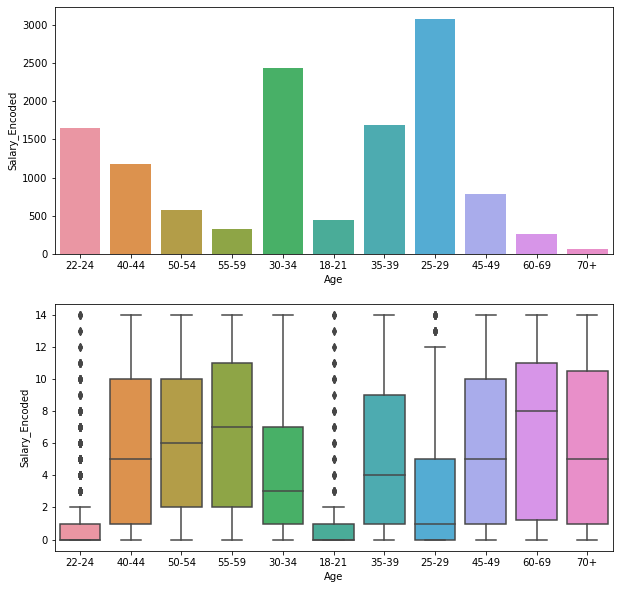

In [31]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q1', ax = ax1)
plt.xlabel('Age')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q1', y='Q10_Encoded', ax = ax2)
plt.xlabel('Age')
plt.ylabel('Salary_Encoded')

We see that age of the survey respondent has a significant influence on their salary with people having higher ages commanding higher salares. 

In [32]:
#It makes sense to encode the Age column with label encoding using middle values of age
encodeDict = {'18-21':20,'22-24':23, '25-29':27, '30-34':32, '35-39': 37, '40-44':42, '45-49':47, '50-54':52, '55-59':57, '60-69':65, '70+':72}
df['Age_Encoded'] = df['Q1']
df['Age_Encoded'].replace(encodeDict, inplace = True)

Text(0, 0.5, 'Salary_Encoded')

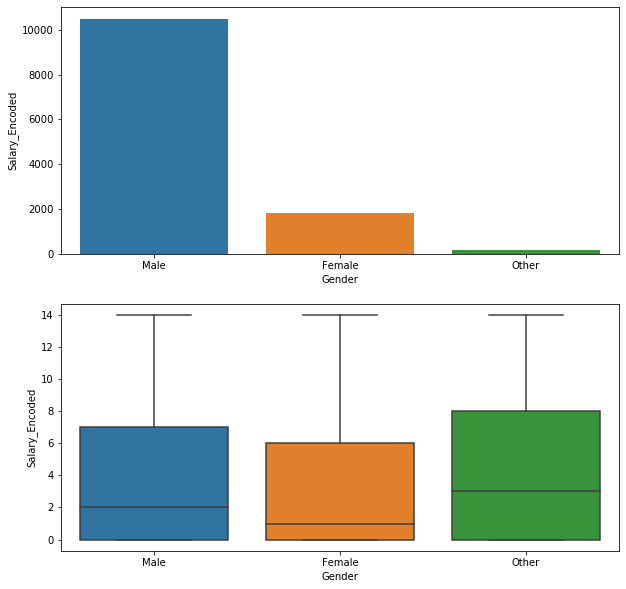

In [33]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q2', ax = ax1)
plt.xlabel('Gender')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q2', y='Q10_Encoded', ax = ax2)
plt.xlabel('Gender')
plt.ylabel('Salary_Encoded')

We don't see a significant difference in salary between males & females, while those who have chosen not to identify their gender seem to command a higher salary in this survey. However, this is something that cannot be generalized since the number of respondents is 'other' category of gender is very low as evidenced by the frequency graph.

Text(0, 0.5, 'Salary_Encoded')

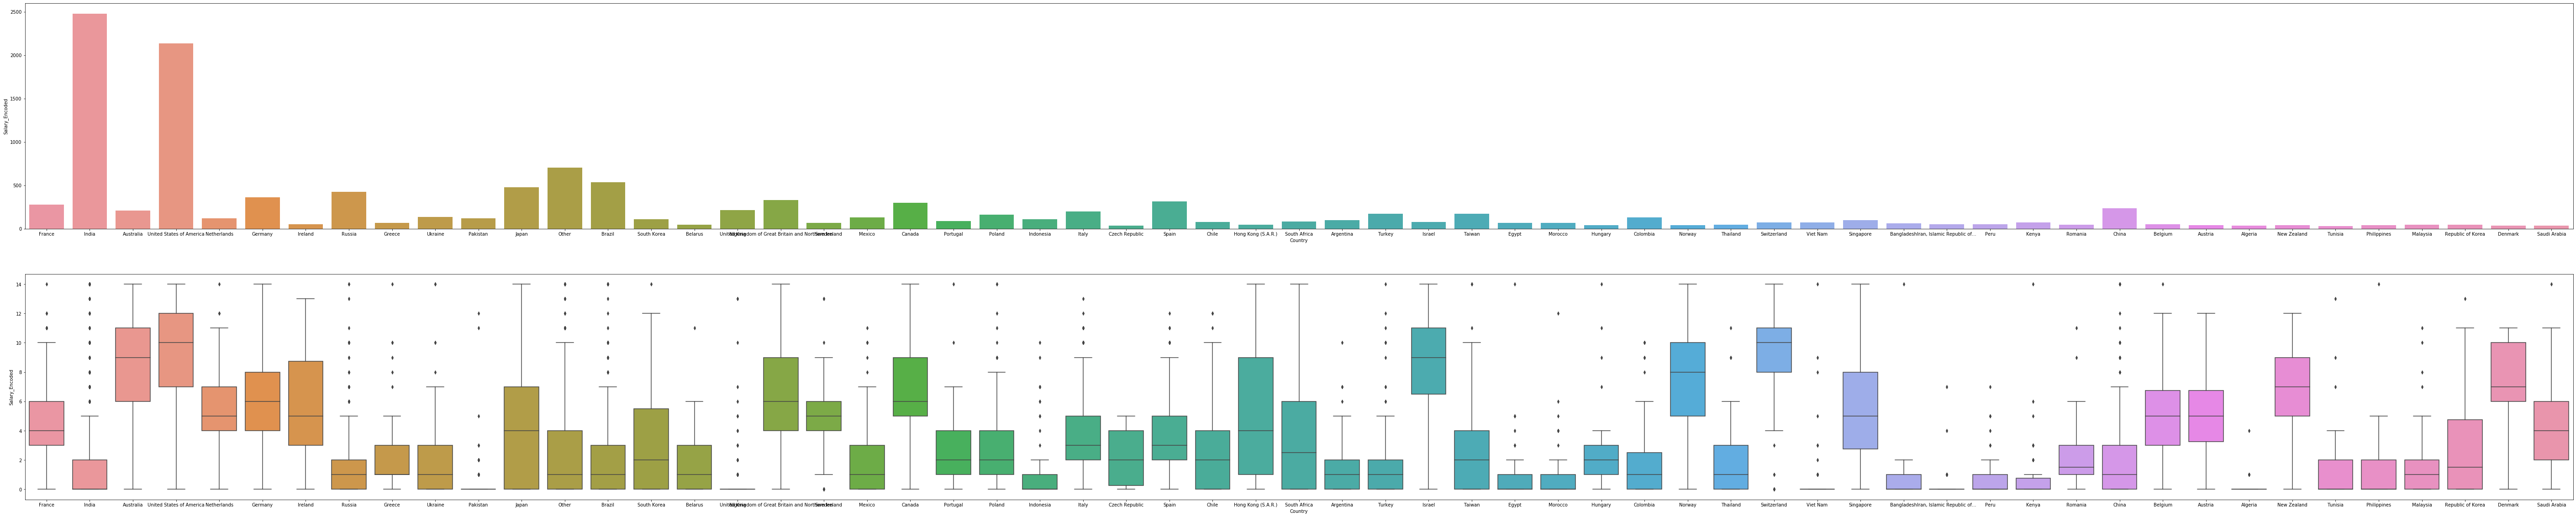

In [34]:
fig = plt.figure(figsize=(100,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q3', ax = ax1)
plt.xlabel('Country')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q3', y='Q10_Encoded', ax = ax2)
plt.xlabel('Country')
plt.ylabel('Salary_Encoded')

The location graph is indeed a very crowded one and necessitates categorization into continents. I have proceeded to categorize each country into a continent but leave out US and India since they represent a significantly high number of respondents & so could potentially skew each continent in their direction. Also, leaving these two countries out could potentially help the logistic regression model to better predict the salary responses of data scientists from these countries.

In [35]:
#It makes sense to group countries based on their contents to reduce the number of columns. However, since the US and India have the most number of entries, we keep them separatel since it could skew the data. 
replaceDict = {'Brazil':'South America', 'Japan':'Asia', 'Russia':'Asia', 'Germany':'Europe', 'United Kingdom of Great Britain and Northern Ireland': 'Europe', 'Spain':'Europe', 'Canada':'North America', 'France':'Europe', 'China':'Asia', 'Nigeria':'Africa', 'Australia':'Oceania', 'Italy':'Europe', 'Turkey':'Europe', 'Taiwan':'Poland', 'Ukraine':'Europe', 'Mexico':'North America', 'Colombia':'South America', 'Pakistan':'Asia', 'Netherlands':'Europe', 'South Korea':'Asia', 'Indonesia':'Asia', 'Singapore':'Asia', 'Argentina':'South America', 'Portugal':'Europe', 'South Africa':'Africa', 'Chile':'South America', 'Israel':'Asia', 'Viet Nam':'Asia', 'Switzerland':'Europe', 'Kenya':'Africa', 'Greece':'Europe', 'Sweden':'Europe', 'Morocco':'Africa', 'Egypt':'Africa', 'Bangladesh':'Asia', 'Belgium':'Asia', 'Iran, Islamic Republic of...':'Asia', 'Peru':'South America', 'Ireland':'Europe', 'Hong Kong (S.A.R.)':'Asia', 'Malaysia':'Asia', 'Republic of Korea':'Asia', 'Belarus':'Europe', 'Thailand':'Asia', 'Romania':'Europe', 'Austria':'Europe','Hungary':'Europe', 'Philippines':'Asia', 'New Zealand':'Oceania', 'Norway':'Europe', 'Denmark':'Europe', 'Czech Republic':'Europe', 'Saudi Arabia':'Asia', 'Algeria':'Africa', 'Tunisia':'Africa'}

df['Q3_continents'] = df['Q3']
df['Q3_continents'].replace(replaceDict, inplace = True)
df['Q3_continents'].replace({'Poland':'Europe'}, inplace = True)

Text(0, 0.5, 'Salary_Encoded')

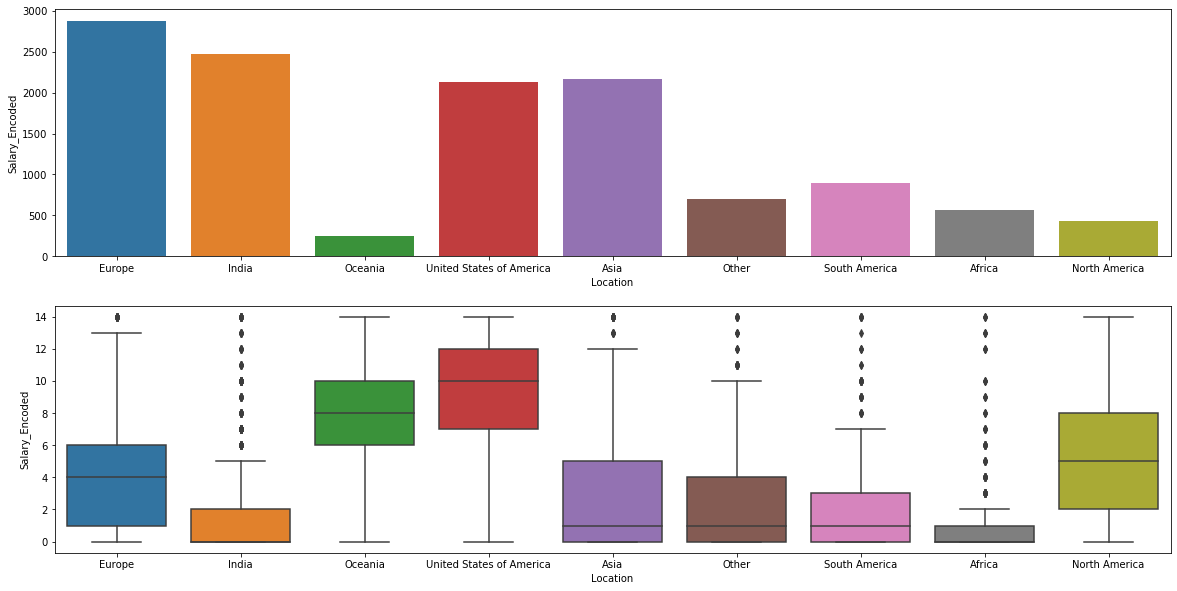

In [36]:
fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q3_continents', ax = ax1)
plt.xlabel('Location')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q3_continents', y='Q10_Encoded', ax = ax2)
plt.xlabel('Location')
plt.ylabel('Salary_Encoded')

After carrying out the grouping, we see that USA & Oceania (continent) command the highest salaries of all the respondents. 

Text(0, 0.5, 'Salary_Encoded')

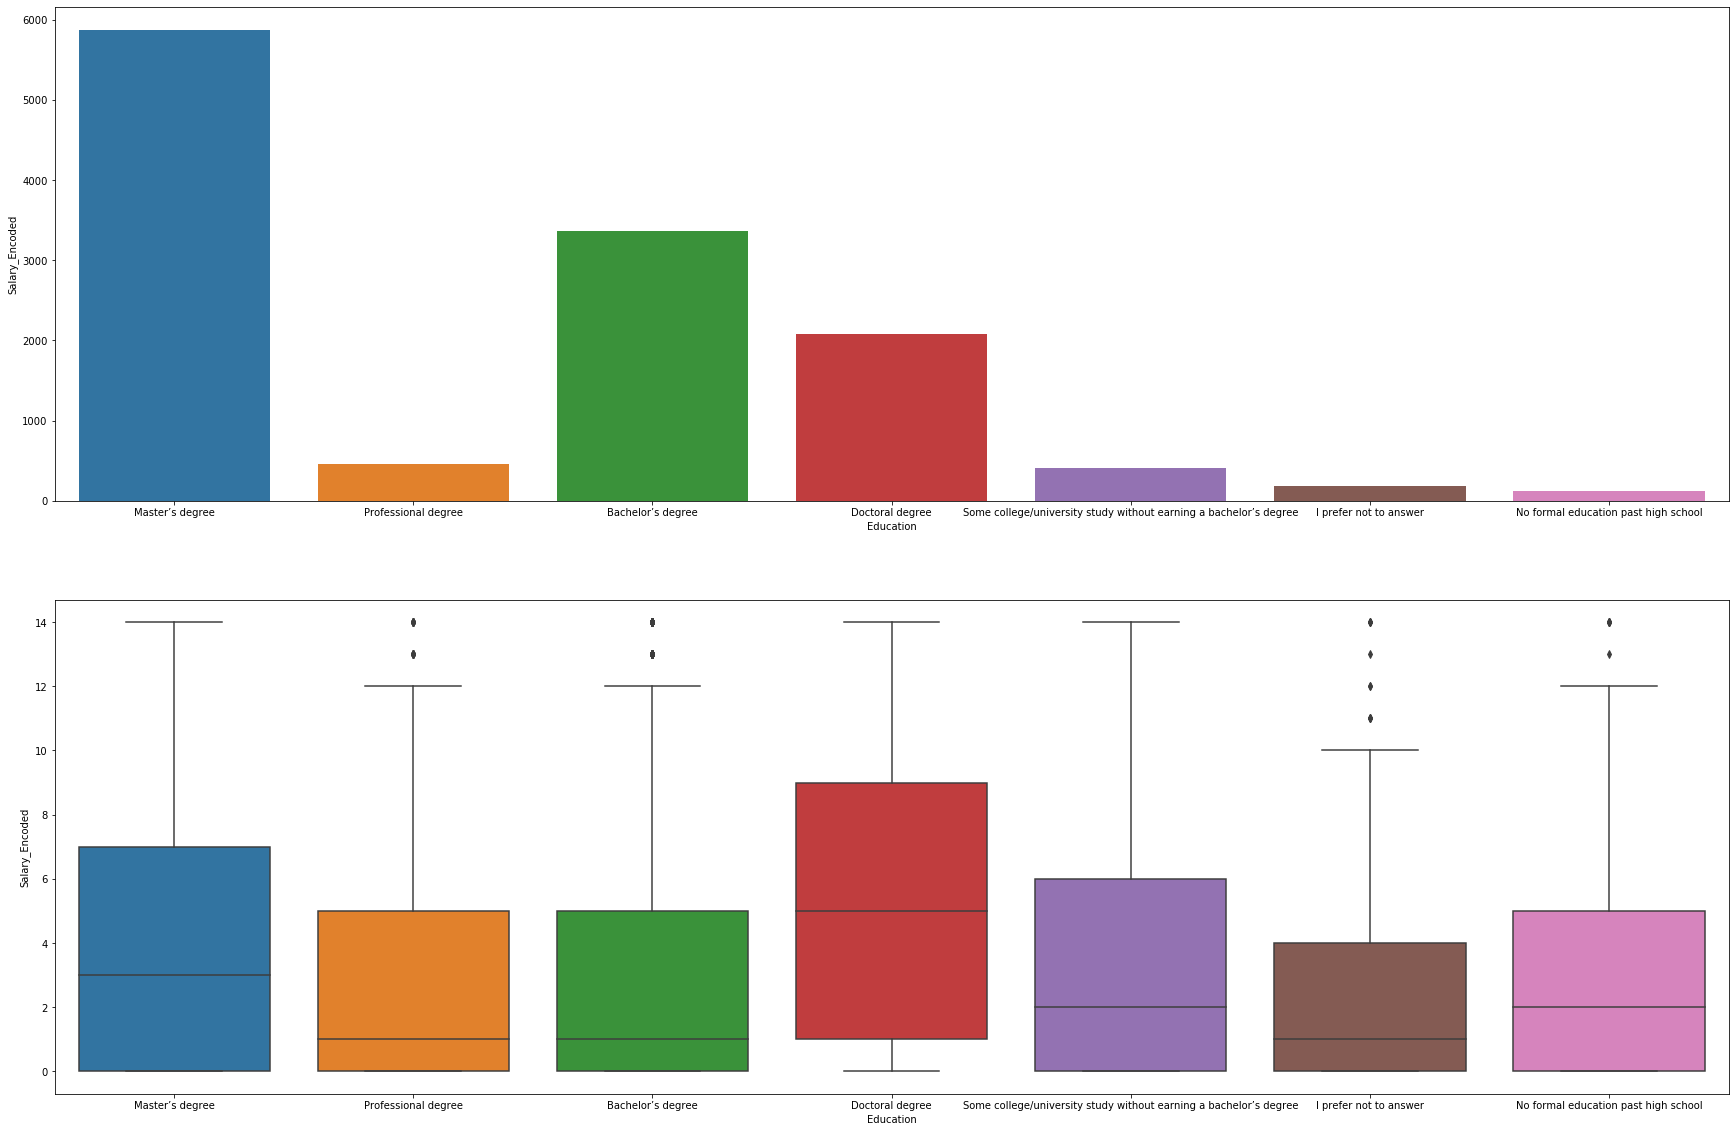

In [37]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q4', ax = ax1)
plt.xlabel('Education')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q4', y='Q10_Encoded', ax = ax2)
plt.xlabel('Education')
plt.ylabel('Salary_Encoded')

From this graph, we can see that those with Doctoral degrees command the highest salaries and this is to be expected. There is also an opportunity to group the last three categories into one: Other, which has been done. 

In [38]:
#It makes sense to group last three categories together as School degree/Diploma
replaceDict = {'Some college/university study without earning a bachelor’s degree':'School', 'I prefer not to answer':'School', 'No formal education past high school':'School'}
df['Q4'].replace(replaceDict, inplace = True)

In [39]:
df['Q4'].unique()

array(['Master’s degree', 'Professional degree', 'Bachelor’s degree',
       'Doctoral degree', 'School'], dtype=object)

Text(0, 0.5, 'Salary_Encoded')

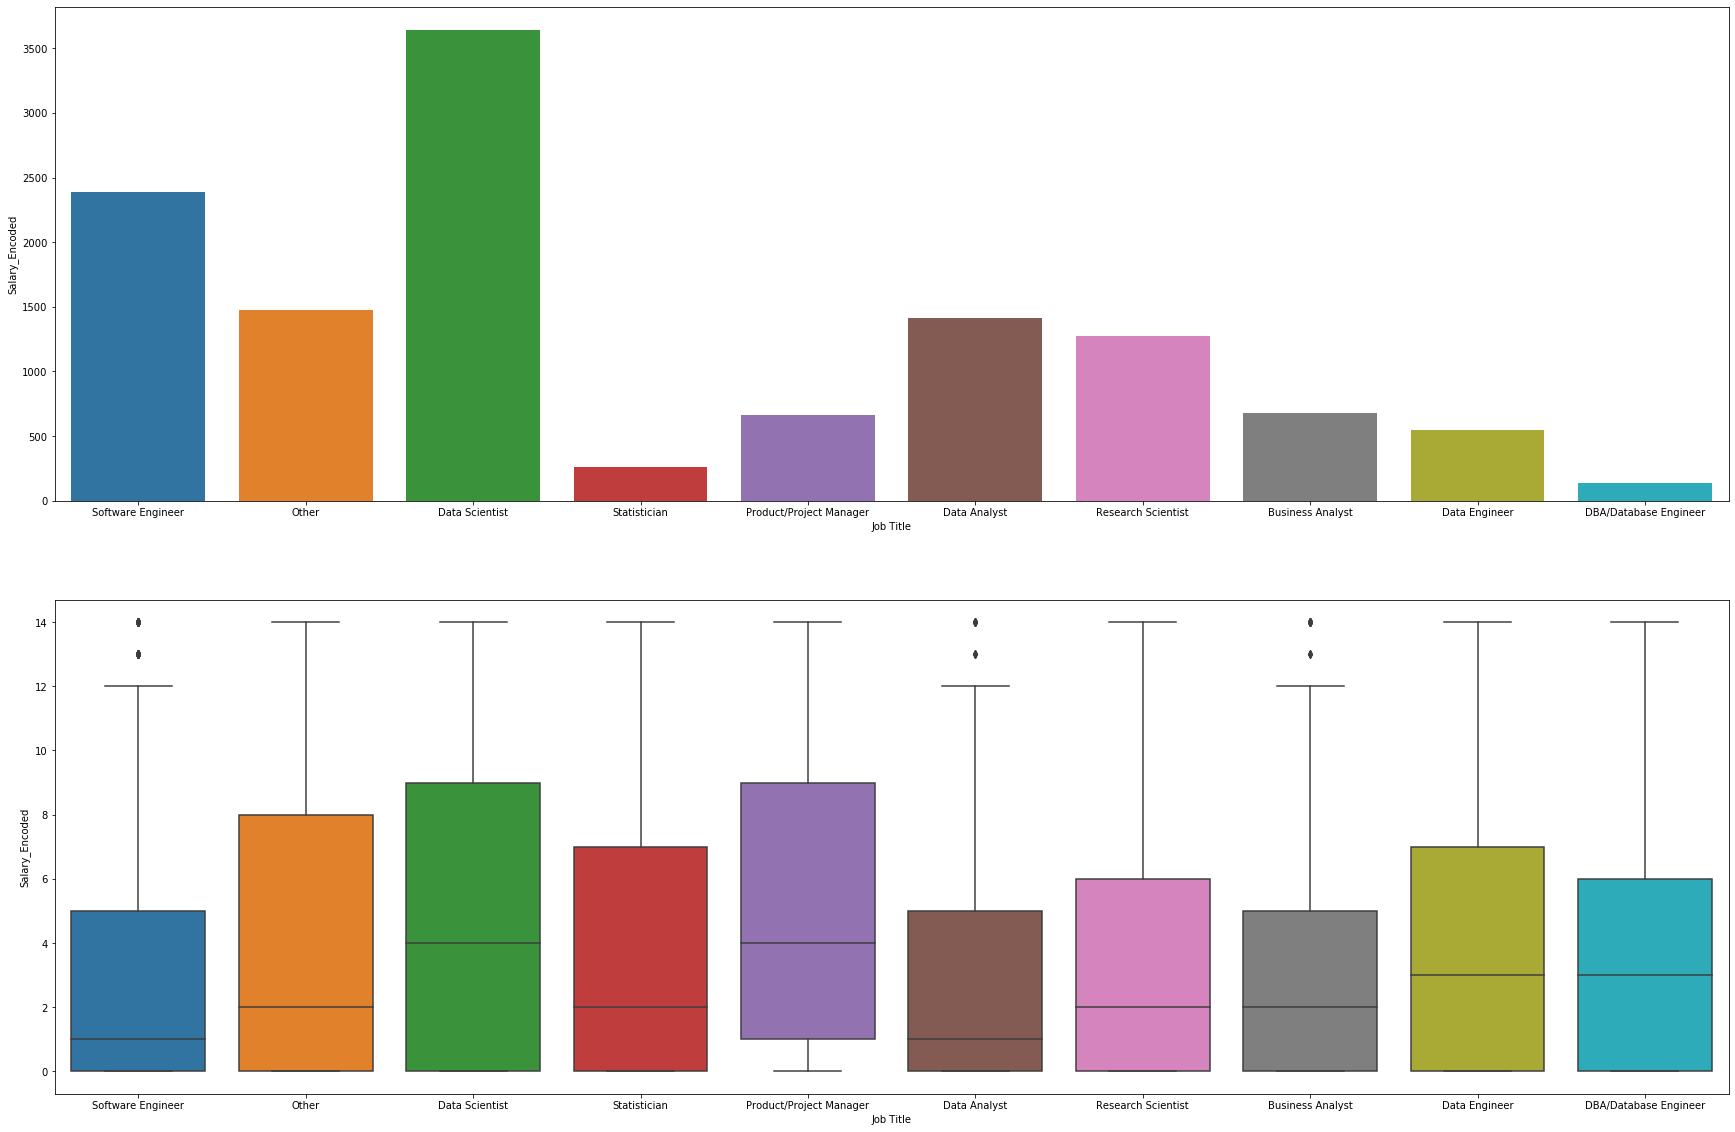

In [40]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q5', ax = ax1)
plt.xlabel('Job Title')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q5', y='Q10_Encoded', ax = ax2)
plt.xlabel('Job Title')
plt.ylabel('Salary_Encoded')

This indicates that there are multiple job titles with varying salaries & necessitates grouping. 

In [41]:
#We can group job titles into different categories: Data Engineering roles, Research oriented roles, IT/Business Roles, Other so as to reduce feature complexity while encoding
replaceDict = {'Data Scientist':'Data Engineering roles', 'Data Analyst':'Data Engineering roles', 'Data Engineer':'Data Engineering roles', 'DBA/Database Engineer':'Data Engineering roles',
             'Statistician':'Research oriented roles','Research Scientist':'Research oriented roles',
             'Software Engineer':'IT/Business roles','Business Analyst':'IT/Business roles', 'Product/Project Manager':'IT/Business roles'}
df['Q5'].replace(replaceDict, inplace = True)

Text(0, 0.5, 'Salary_Encoded')

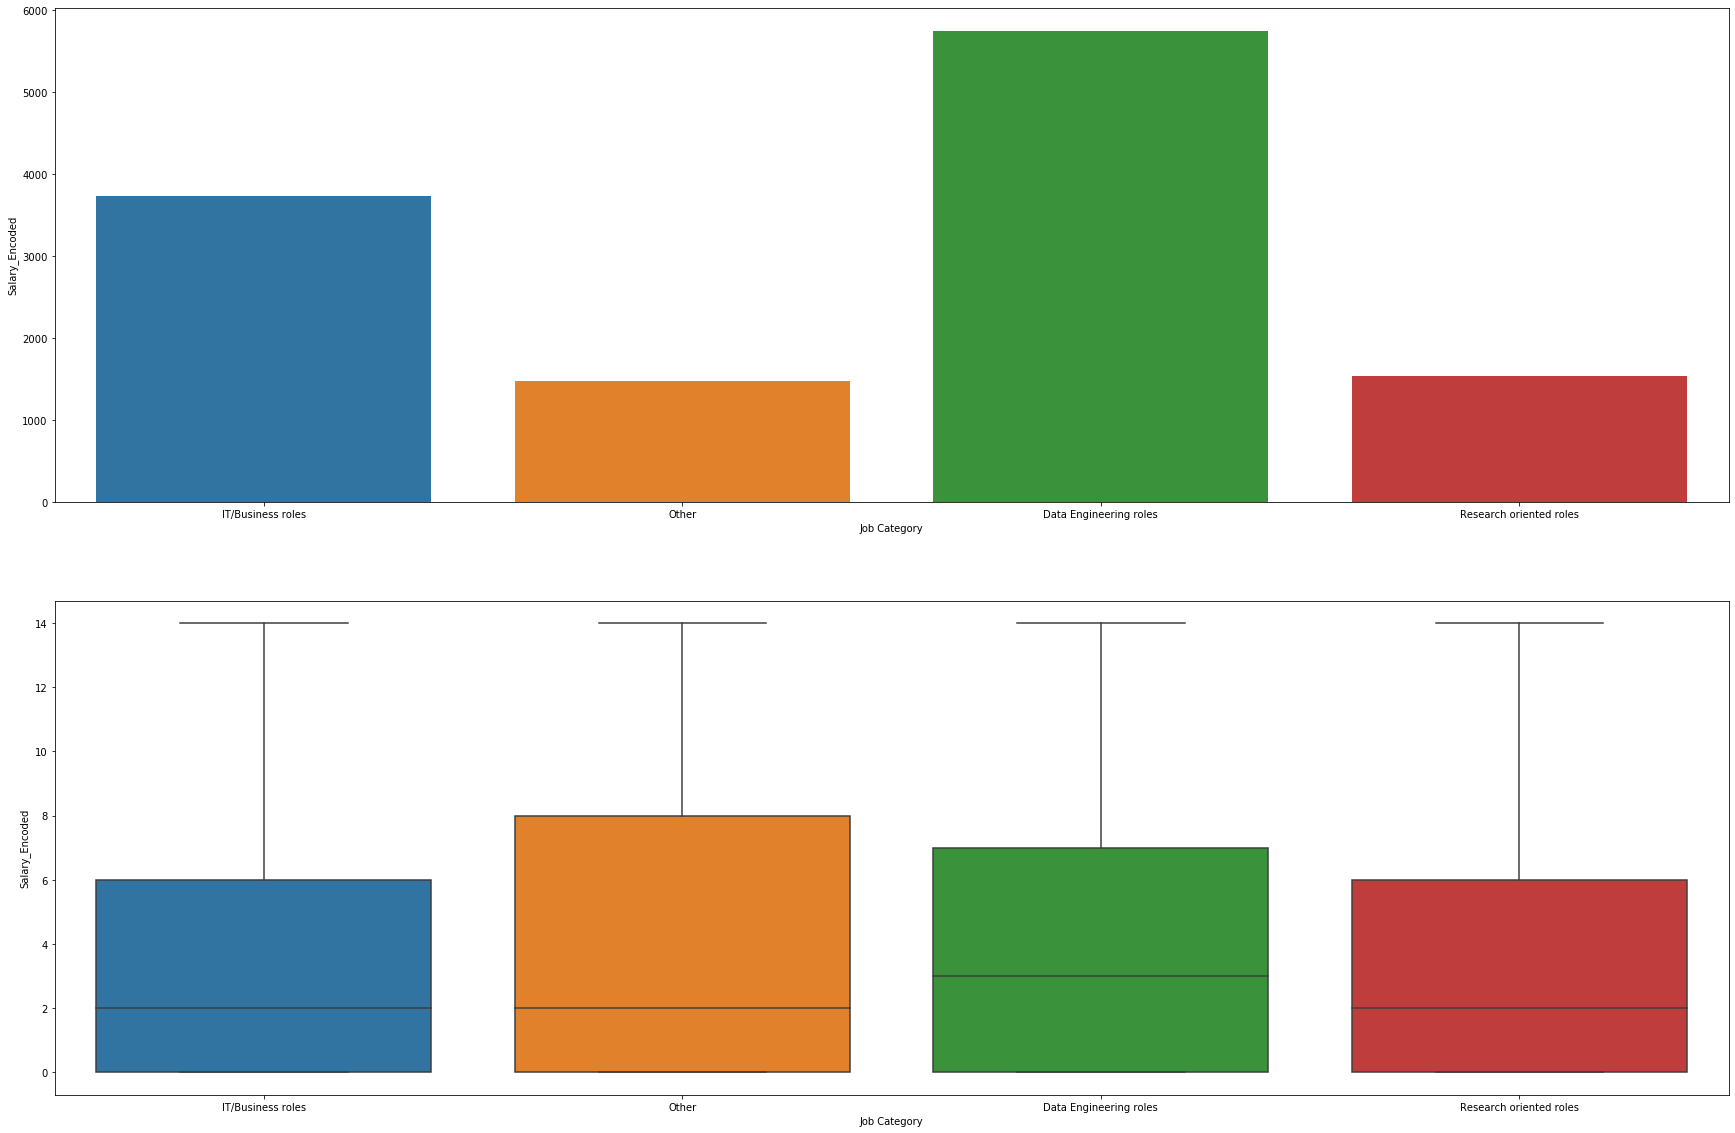

In [42]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q5', ax = ax1)
plt.xlabel('Job Category')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q5', y='Q10_Encoded', ax = ax2)
plt.xlabel('Job Category')
plt.ylabel('Salary_Encoded')

From this graph, we can see that data engineering roles seem to make a higher salary on average as compared to the other classes of roles.

Text(0, 0.5, 'Salary_Encoded')

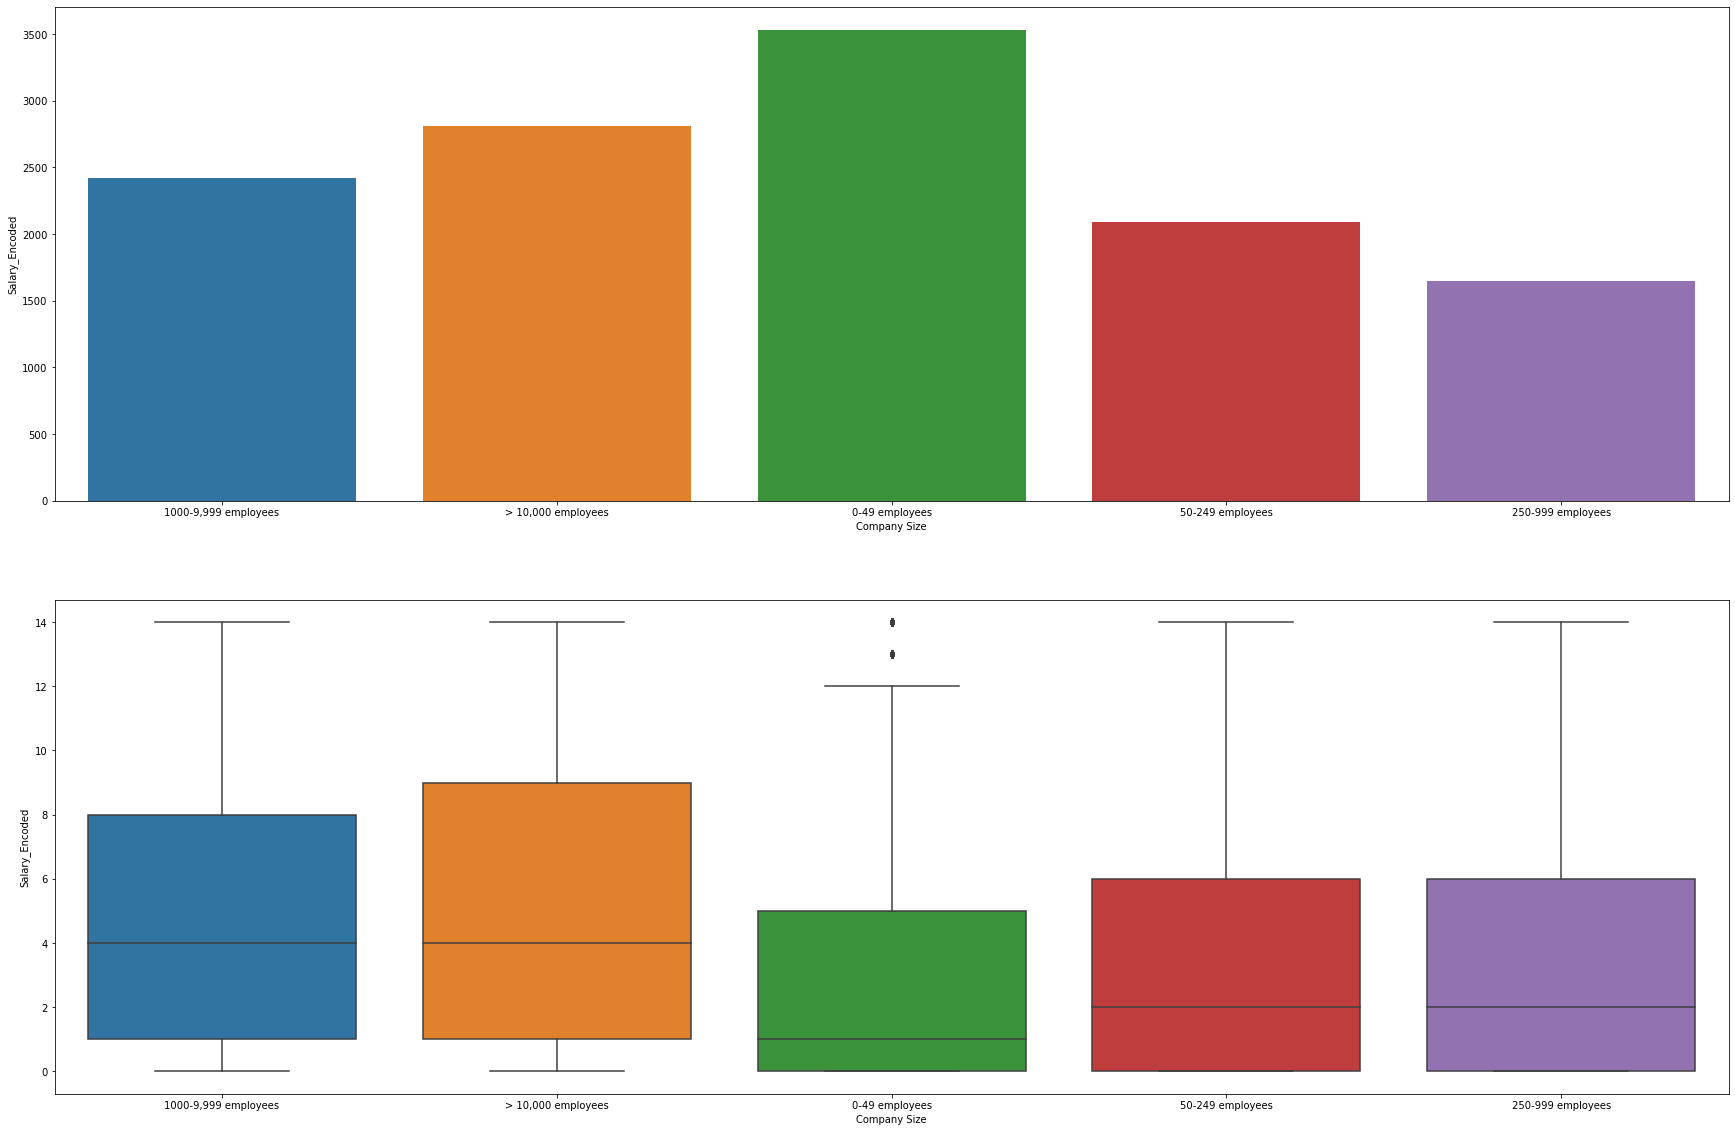

In [43]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q6', ax = ax1)
plt.xlabel('Company Size')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q6', y='Q10_Encoded', ax = ax2)
plt.xlabel('Company Size')
plt.ylabel('Salary_Encoded')

From this chart, we see there exists a relationship between size of company and the salary received by the respondents with companies having greater than 10000 employees making the most on average.

Text(0, 0.5, 'Salary_Encoded')

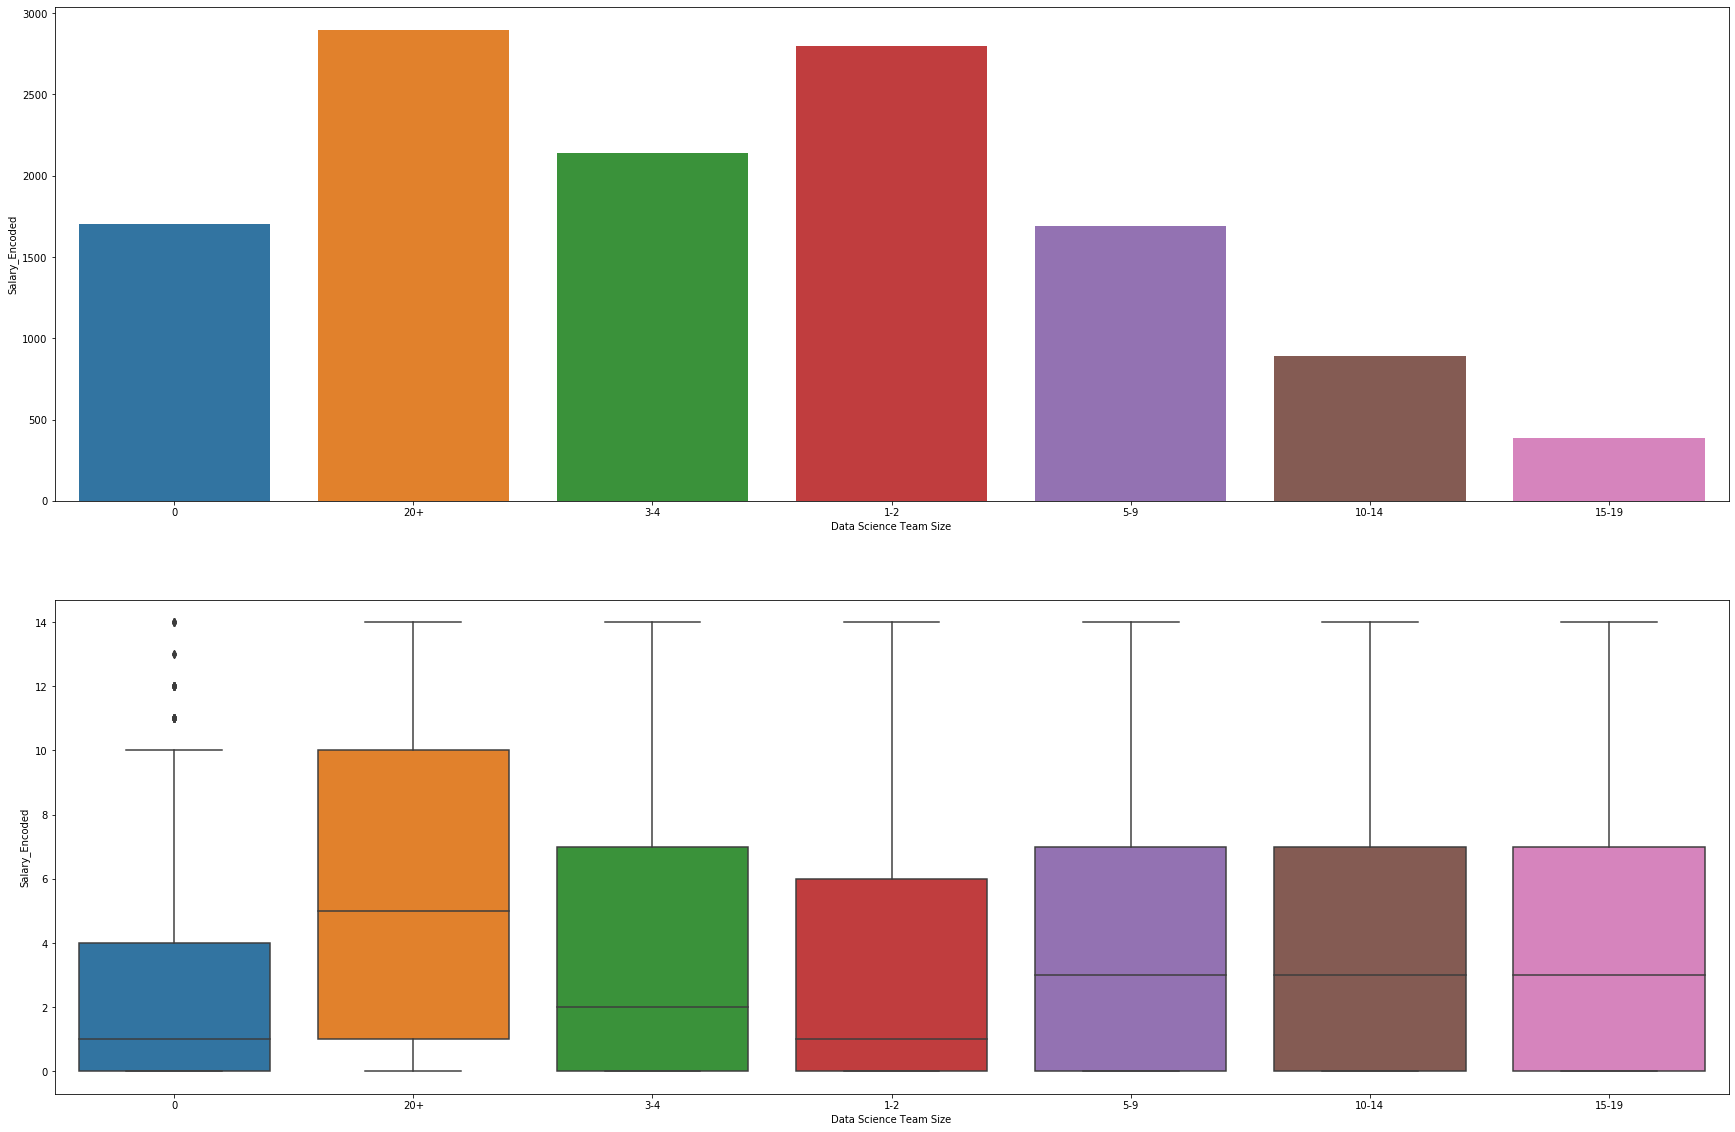

In [44]:
fig = plt.figure(figsize=(30,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q7', ax = ax1)
plt.xlabel('Data Science Team Size')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q7', y='Q10_Encoded', ax = ax2)
plt.xlabel('Data Science Team Size')
plt.ylabel('Salary_Encoded')

It can be seen that data sciences with a team sizes of larger than 20 get paid the highest salaries on average. However, the caveat is that this bucket includes all team sizes from twenty going all the way to hundreds. So, it can be inferrred that data science team size does not radically determine the salary of survey respondent and this feature can be further grouped to reduce feature complexity.

In [45]:
#Data science team sizes can be grouped into categories of 0, 1 - 4, 5 - 9, 10 - 20, 20+
replaceDict = {'1-2':'1-4', '3-4':'1-4', '10-14':'10-20', '15-19':'10-20'}
df['Q7'].replace(replaceDict, inplace = True)

In [46]:
df['Q7'].unique()

array(['0', '20+', '1-4', '5-9', '10-20'], dtype=object)

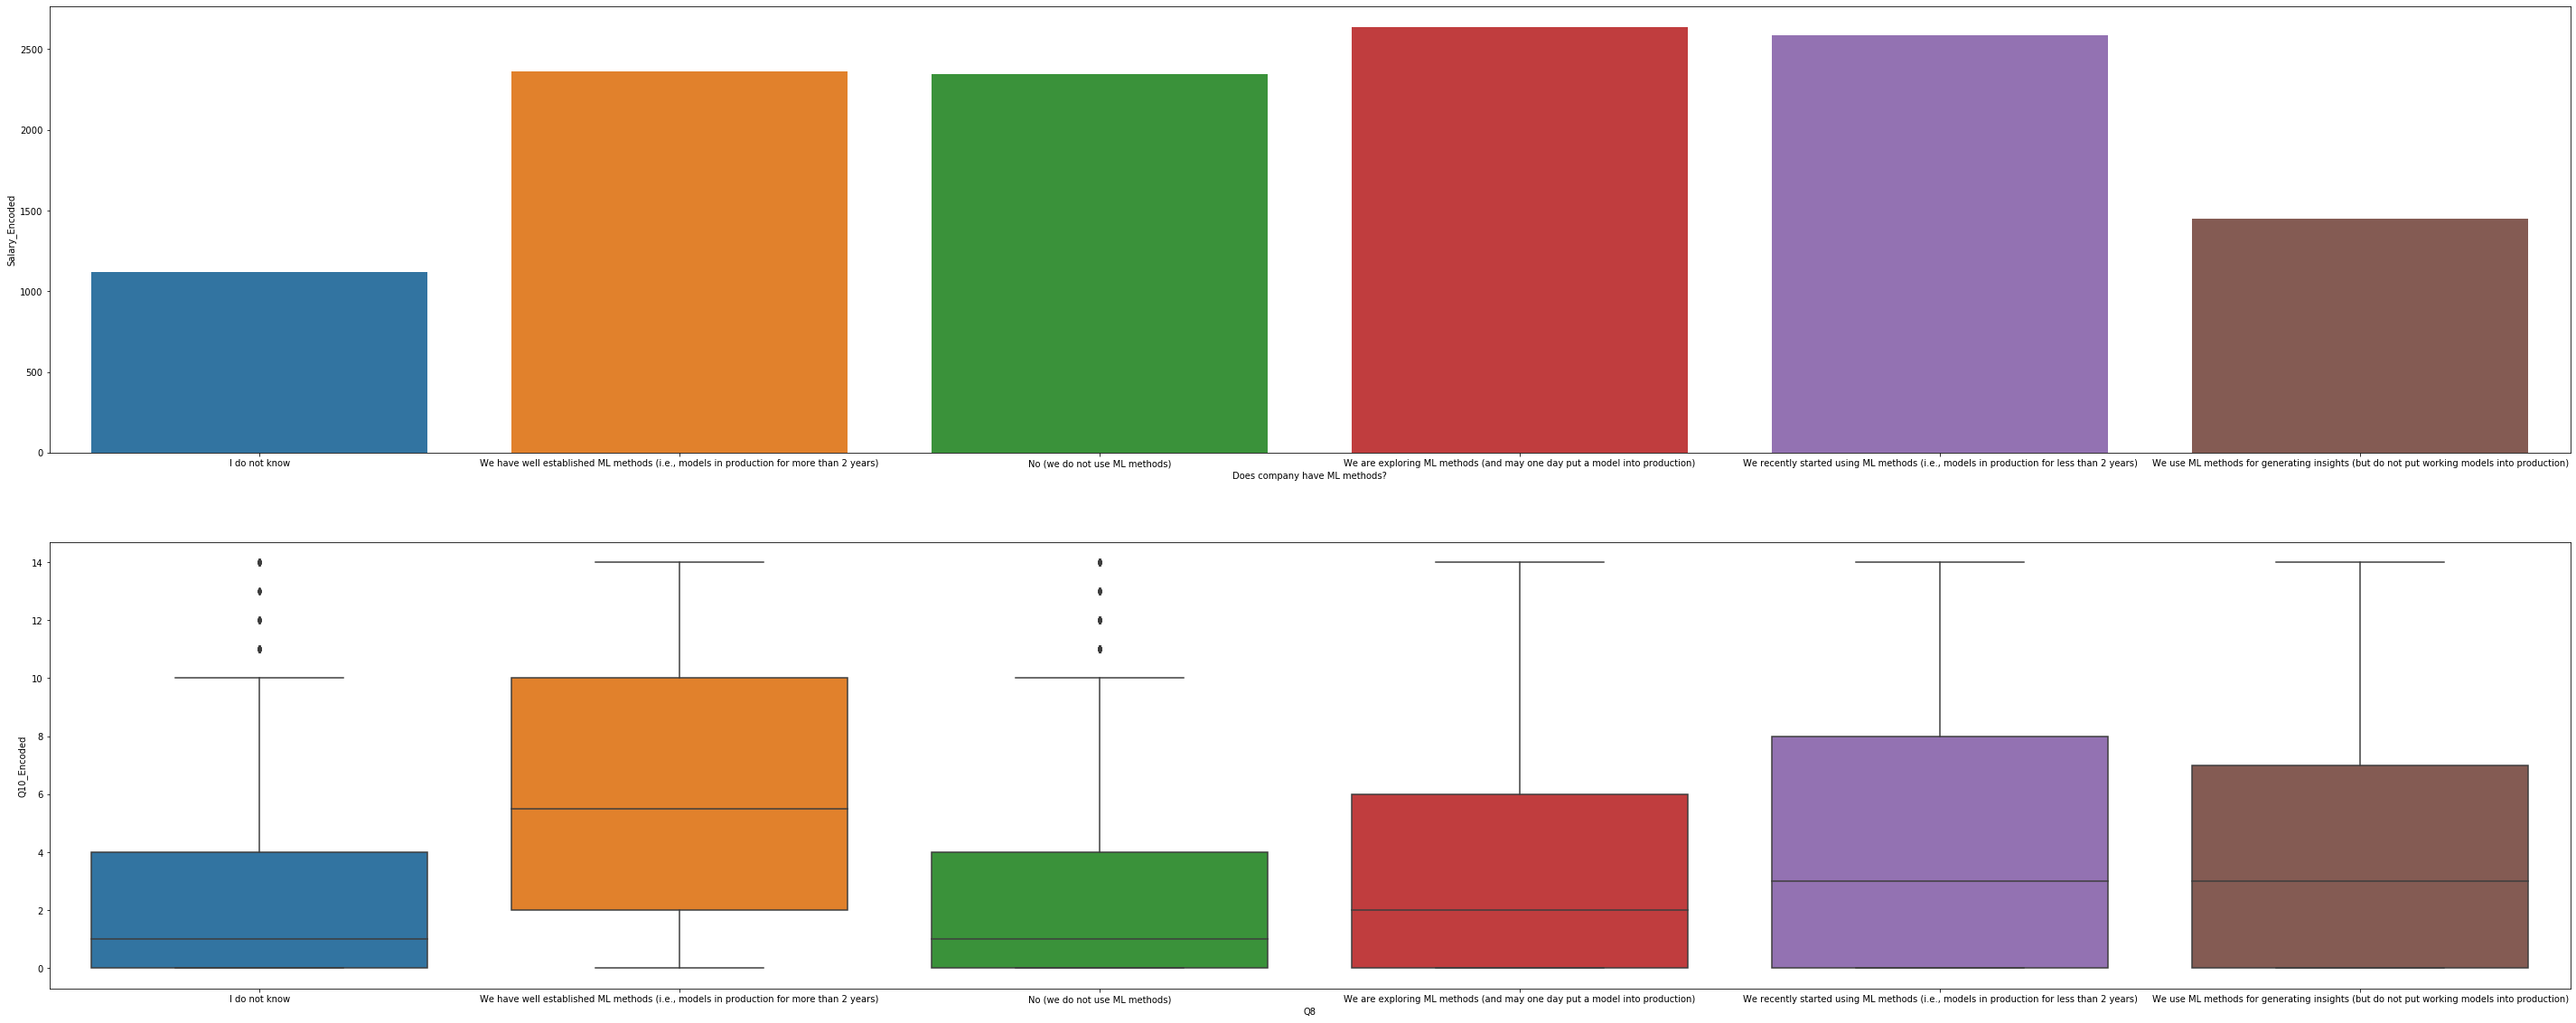

In [47]:
fig = plt.figure(figsize=(50,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q8', ax = ax1)
plt.xlabel('Does company have ML methods?')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
plt.xlabel('Does company have ML methods?')
plt.ylabel('Salary_Encoded')
sns.boxplot(data = df, x='Q8', y='Q10_Encoded', ax = ax2)

From this graph, we can see that companies that have well-established ML methods have data scientists that get paid the most. Also, this provides an opportunity to group data scientists based on whether the companies they work in use ML methods or not. 

In [48]:
#This can be reduced to whether the company uses ML methods or not, so we can switch this to a binary Y/N question
replaceDict = {'No (we do not use ML methods)':'No','I do not know':'No','We have well established ML methods (i.e., models in production for more than 2 years)':'Yes','We are exploring ML methods (and may one day put a model into production)':'No', 'We recently started using ML methods (i.e., models in production for less than 2 years)':'Yes', 'We use ML methods for generating insights (but do not put working models into production)':'Yes'}
df['Q8'].replace(replaceDict, inplace = True)

In [49]:
def rename_func(row):
    if (row['Q9_Part_1'] == 1):
        return 'Analyze & understand data to influence decisions'
    elif (row['Q9_Part_2'] == 1):
        return 'Build and/or run data infrastructure'
    elif (row['Q9_Part_3'] == 1):
        return 'Build prototypes to explore & apply ML'
    elif (row['Q9_Part_4'] == 1):
        return 'Build and/or run a ML service'
    elif (row['Q9_Part_5'] == 1):
        return 'Experimentation and iteration to improve existing models'
    elif (row['Q9_Part_6'] == 1):
        return 'Do research that advances state of ML'
    elif (row['Q9_Part_7'] == 1):
        return 'None'
    elif (row['Q9_Part_8'] == 1):
        return 'Other'
    else:
        return 'None'   
df['Q9_Responses'] = df.apply(lambda row: rename_func(row), axis = 1)

Text(0, 0.5, 'Salary_Encoded')

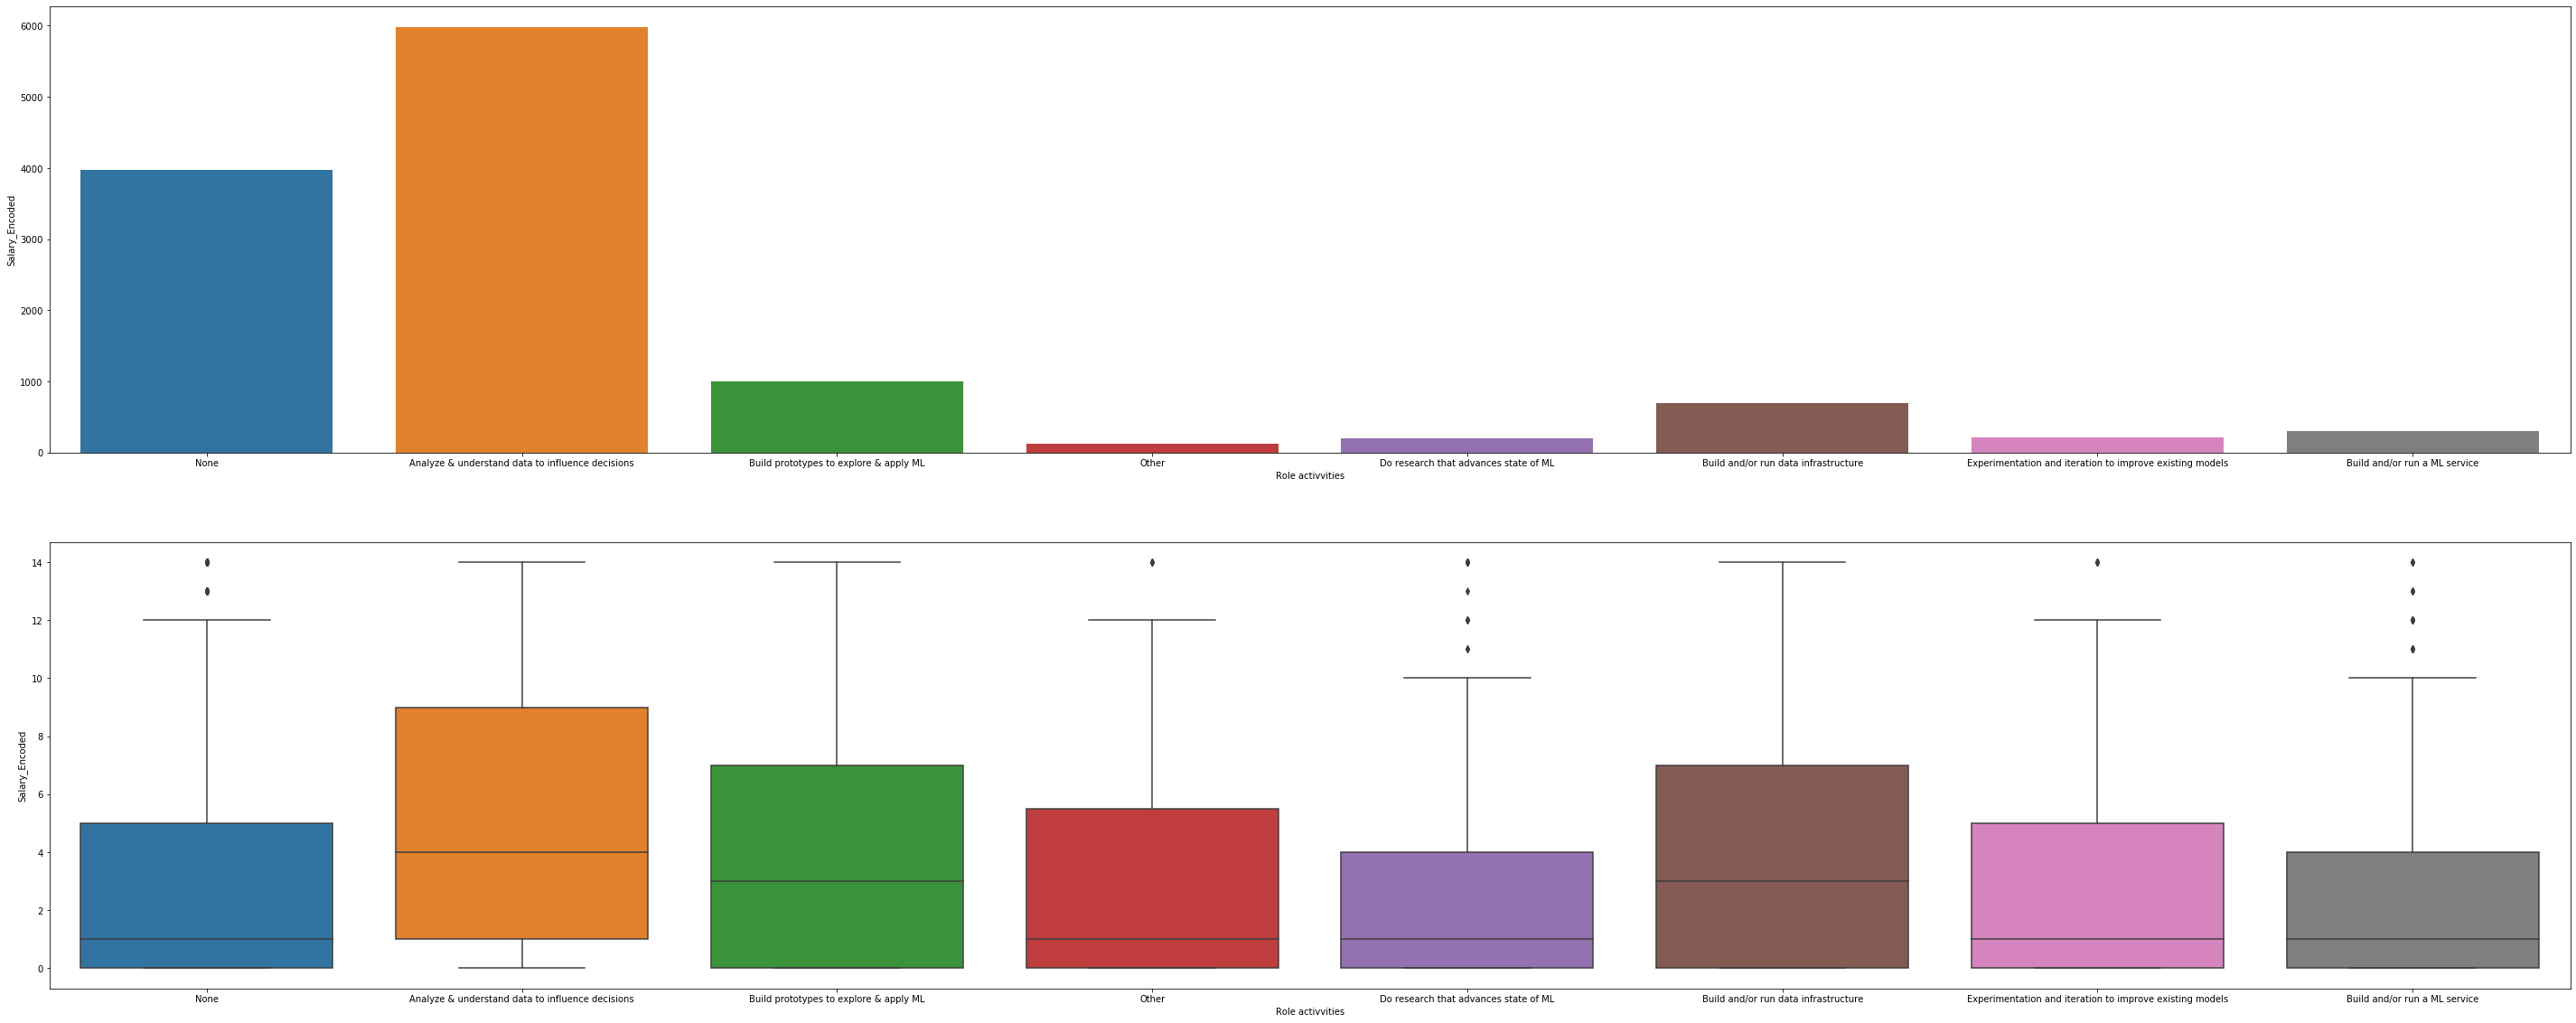

In [50]:
fig = plt.figure(figsize=(50,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q9_Responses', ax = ax1)
plt.xlabel('Role activvities')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q9_Responses', y='Q10_Encoded', ax = ax2)
plt.xlabel('Role activvities')
plt.ylabel('Salary_Encoded')

From this graph, it can be noted that most people use data science to analyze data to aid in decision-making. This seems to result in higher salaries as well primarily due to their ability to directly influence decision making in businesses. We can also group these activvities as Data Science or ML oriented activities. 

In [51]:
df['Q9_Responses'].value_counts()

Analyze & understand data to influence decisions            5979
None                                                        3977
Build prototypes to explore & apply ML                      1005
Build and/or run data infrastructure                         699
Build and/or run a ML service                                308
Experimentation and iteration to improve existing models     210
Do research that advances state of ML                        200
Other                                                        119
Name: Q9_Responses, dtype: int64

In [52]:
#Now we can group these responses into three categories: Data Scientist, Machine Learning activities
replaceDict = {'Analyze & understand data to influence decisions':'Data Science activity',
              'Build prototypes to explore & apply ML': 'Machine Learning activity',
    'Do research that advances state of ML': 'Machine Learning activity',
         'Build and/or run data infrastructure': 'Data Science activity', 
           'Experimentation and iteration to improve existing models':'Machine Learning activity',
               'Build and/or run a ML service': 'Machine Learning activity', 'None':'Other', 'Other':'Other'}
df['Q9_Responses'].replace(replaceDict, inplace = True)

#Now that we have these responses, we can drop Q9_Part_1 through 8
for i in range(8):
    df.drop(columns=['Q9_Part_%d' %(i+1)], inplace = True)

In [53]:
df['Q9_Responses'].value_counts()

Data Science activity        6678
Other                        4096
Machine Learning activity    1723
Name: Q9_Responses, dtype: int64

In [54]:
#Since Q13 has respondents who have taken a mixture of these courses, it is rather hard to map & encode. So, we drop
for i in range(12):
    df.drop(columns = ['Q13_Part_%d' %(i+1)], inplace = True)

Text(0, 0.5, 'Salary_Encoded')

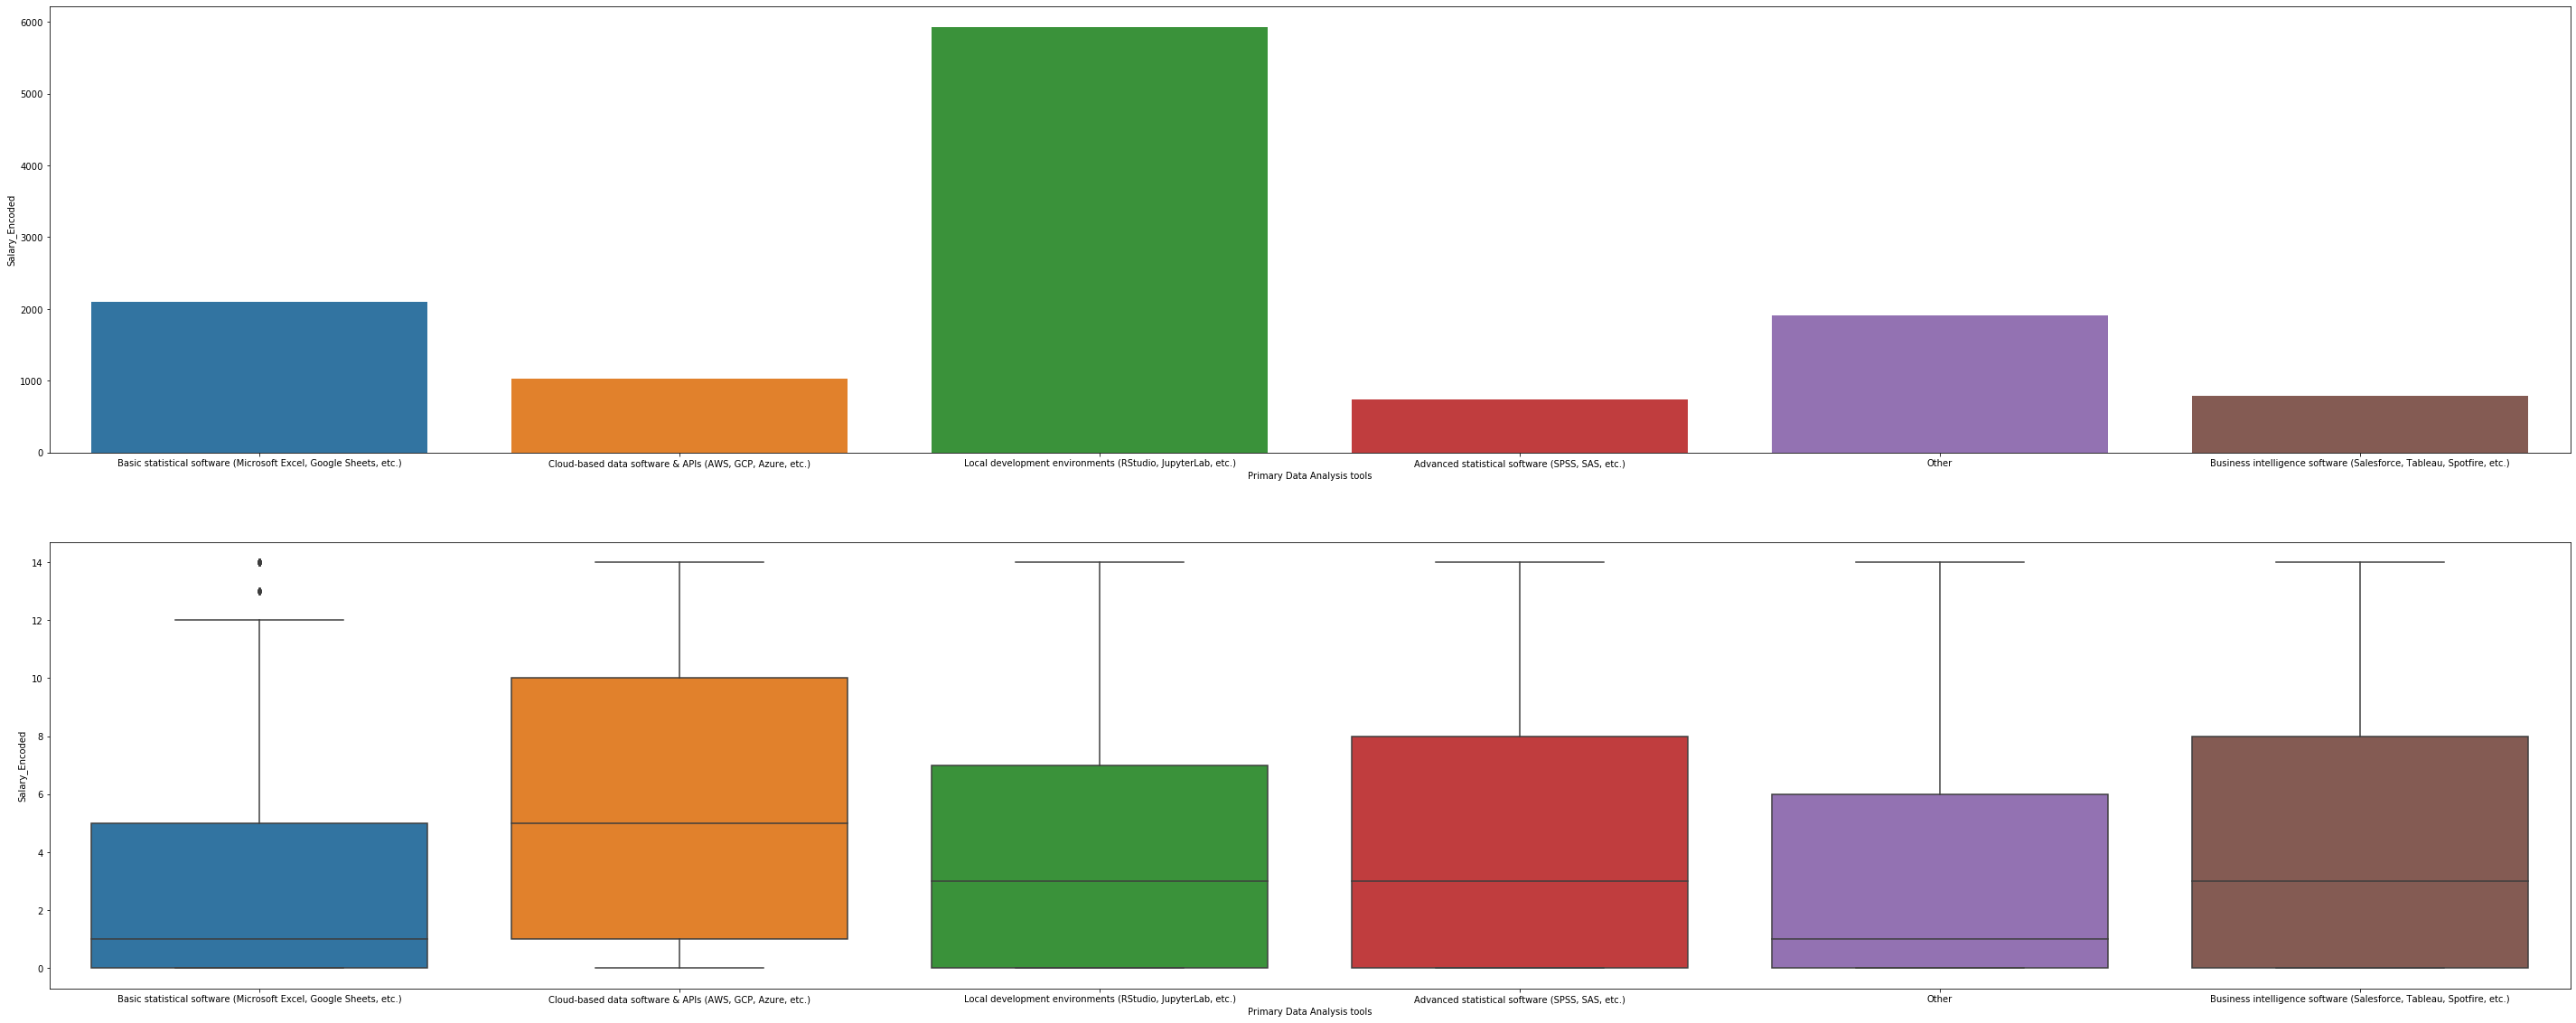

In [55]:
fig = plt.figure(figsize=(50,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q14', ax = ax1)
plt.xlabel('Primary Data Analysis tools')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q14', y='Q10_Encoded', ax = ax2)
plt.xlabel('Primary Data Analysis tools')
plt.ylabel('Salary_Encoded')

While most people prefer to work on local environments such as Jupyter as shown by the count plot, it can be observed that the few who work on cloud-based platform command relatively higher salries on average. This is perhaps due to the fact those who use cloud-based platforms generally use relatively more advanced ML/data tools that are required for more complex businesses that pay their employees more.

Text(0, 0.5, 'Salary_Encoded')

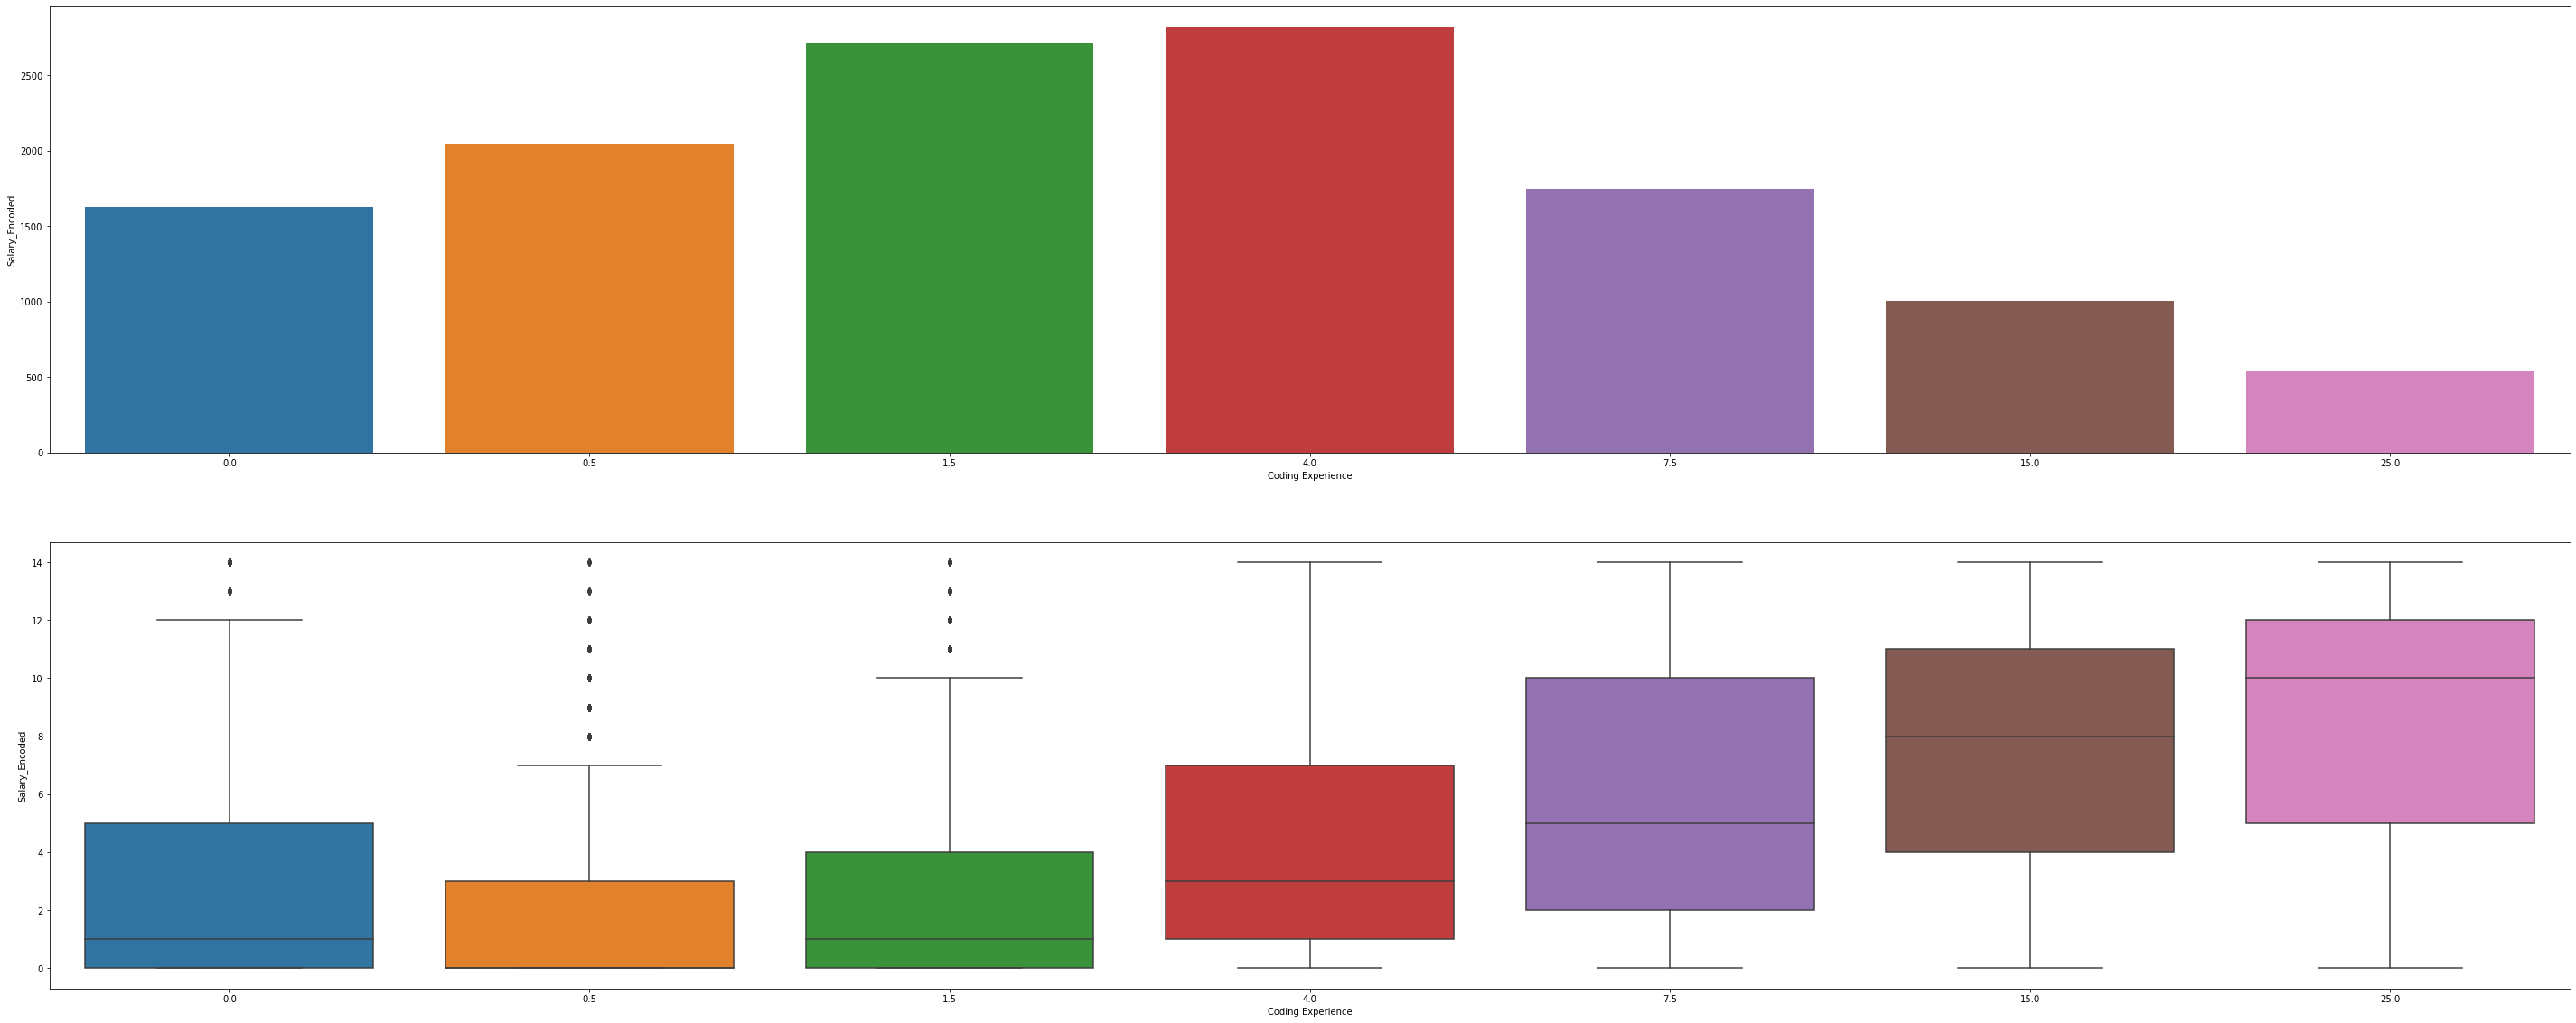

In [56]:
fig = plt.figure(figsize=(50,20))

ax1 = fig.add_subplot(2,1,1) 
sns.countplot(data = df, x = 'Q15_Encoded', ax = ax1)
plt.xlabel('Coding Experience')
plt.ylabel('Salary_Encoded')

ax2 = fig.add_subplot(2,1,2) 
sns.boxplot(data = df, x='Q15_Encoded', y='Q10_Encoded', ax = ax2)
plt.xlabel('Coding Experience')
plt.ylabel('Salary_Encoded')

We observe that coding experience strongly determines salary of the respondent with those with 20+ years commanding the highest salary on average. This follows naturally since those who are fluent in coding can quickly pick up the programming required to be an astute data scientist.

In [57]:
#Programming Language Categorization into typial languages used for data science (Python, R, SQL) & others (Binary)
def programminglanguage_encoder(row):
    if (row['Q18_Part_1'] == 1 or row['Q18_Part_2'] == 1 or row['Q18_Part_3'] == 1):
        return 1
    else:
        return 0
df['Q18_Encoded'] = df.apply(lambda row: programminglanguage_encoder(row), axis = 1)

In [58]:
#Since choice of IDE, visualization liraries & platform tools is a matter of preference between data scientists, it intuitively makes sense to drop these two features & columns associated with them
for i in range(12):
    df.drop(columns = ['Q16_Part_%d' %(i+1),'Q17_Part_%d' %(i+1), 'Q20_Part_%d' %(i+1) ], inplace = True)

In [59]:
#Specialized Hardware Encoding: TPU, GPU, CPU
def hardware_encoder(row):
    if (row['Q21_Part_3'] == 1):
        return 'TPU'
    elif (row['Q21_Part_2'] == 1):
        return 'GPU'
    elif(row['Q21_Part_1'] == 1):
        return 'CPU'
    else:
        return 'None'
df['Q21_Encoded'] = df.apply(lambda row: hardware_encoder(row), axis = 1)

In [60]:
#ML tools usage encoding based on Q24: Categorize into Basic ML approaches, Deep Neural Networks & Others to reduce complexity
def ML_encoder(row):
    if (row['Q24_Part_6'] == 1 or row['Q24_Part_7'] == 1 or row['Q24_Part_8'] == 1 or row['Q24_Part_9'] == 1):
        return 'Deep Neural Networks'
    elif (row['Q24_Part_1'] == 1 or row['Q24_Part_2'] == 1 or row['Q24_Part_3'] == 1 or row['Q24_Part_4'] == 1):
        return 'Basic ML approaches'
    else:
        return 'Others'
df['Q24_Encoded'] = df.apply(lambda row: ML_encoder(row), axis = 1)    

In [61]:
#Automated ML tools (binary): 1 or 0
def AutomatedML(row):
    if(row['Q25_Part_1'] == 1 or row['Q25_Part_2'] == 1 or row['Q25_Part_3'] == 1 or row['Q25_Part_4'] == 1 or row['Q25_Part_5'] == 1 or row['Q25_Part_6'] == 1):
        return 1
    else:
        return 0
df['Q25_Encoded'] = df.apply(lambda row:AutomatedML(row), axis = 1)

In [62]:
#Computer Vision Feature Engineering: Change it to binary (1/0): either they use computer vision or not
def rename_func2(row):
    if (row['Q26_Part_1'] == 1):
        return 1
    elif (row['Q26_Part_2'] == 1):
        return 1
    elif (row['Q26_Part_3'] == 1):
        return 1
    elif (row['Q26_Part_4'] == 1):
        return 1
    elif (row['Q26_Part_5'] == 1):
        return 1
    elif (row['Q26_Part_6'] == 1):
        return 0
    elif (row['Q26_Part_7'] == 1):
        return 1
    else:
        return 0  
df['Q26_Encoded'] = df.apply(lambda row: rename_func2(row), axis = 1)

In [63]:
#NLP (1/0): Either they use NLP or not 
def rename_func3(row):
    if (row['Q27_Part_1'] == 1):
        return 1
    elif (row['Q27_Part_2'] == 1):
        return 1
    elif (row['Q27_Part_3'] == 1):
        return 1
    elif (row['Q27_Part_4'] == 1):
        return 1
    elif (row['Q27_Part_5'] == 1):
        return 0
    elif (row['Q27_Part_6'] == 1):
        return 1
    else:
        return 0 
df['Q27_Encoded'] = df.apply(lambda row: rename_func3(row), axis = 1)

In [64]:
def rename_func4(row, QNo):
    if (row['Q%d_Part_1' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_2' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_3' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_4' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_5' %QNo] == 1):
        return 0
    elif (row['Q%d_Part_6' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_7' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_8' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_9' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_10' %QNo] == 1):
        return 1
    elif (row['Q%d_Part_11' %QNo] == 1):
        return 0
    elif (row['Q%d_Part_12' %QNo] == 1):
        return 1
    else:
        return 0 

In [65]:
#Cloud Computing (1/0): Either they use cloud computing platforms or not 
df['Q29_Encoded'] = df.apply(lambda row: rename_func4(row,29), axis = 1)

In [66]:
#Data Analytics products (1/0): Either they use data analytics products or not 
df['Q31_Encoded'] = df.apply(lambda row: rename_func4(row,31), axis = 1)

In [67]:
#ML products (binary encoding)
df['Q32_Encoded'] = df.apply(lambda row: rename_func4(row,32), axis = 1)

In [68]:
#Automated ML tools
df['Q33_Encoded'] = df.apply(lambda row: rename_func4(row,33), axis = 1)

In [69]:
#RDBMS tools
df['Q34_Encoded'] = df.apply(lambda row: rename_func4(row,34), axis = 1)

Text(0, 0.5, 'Salary_Encoded')

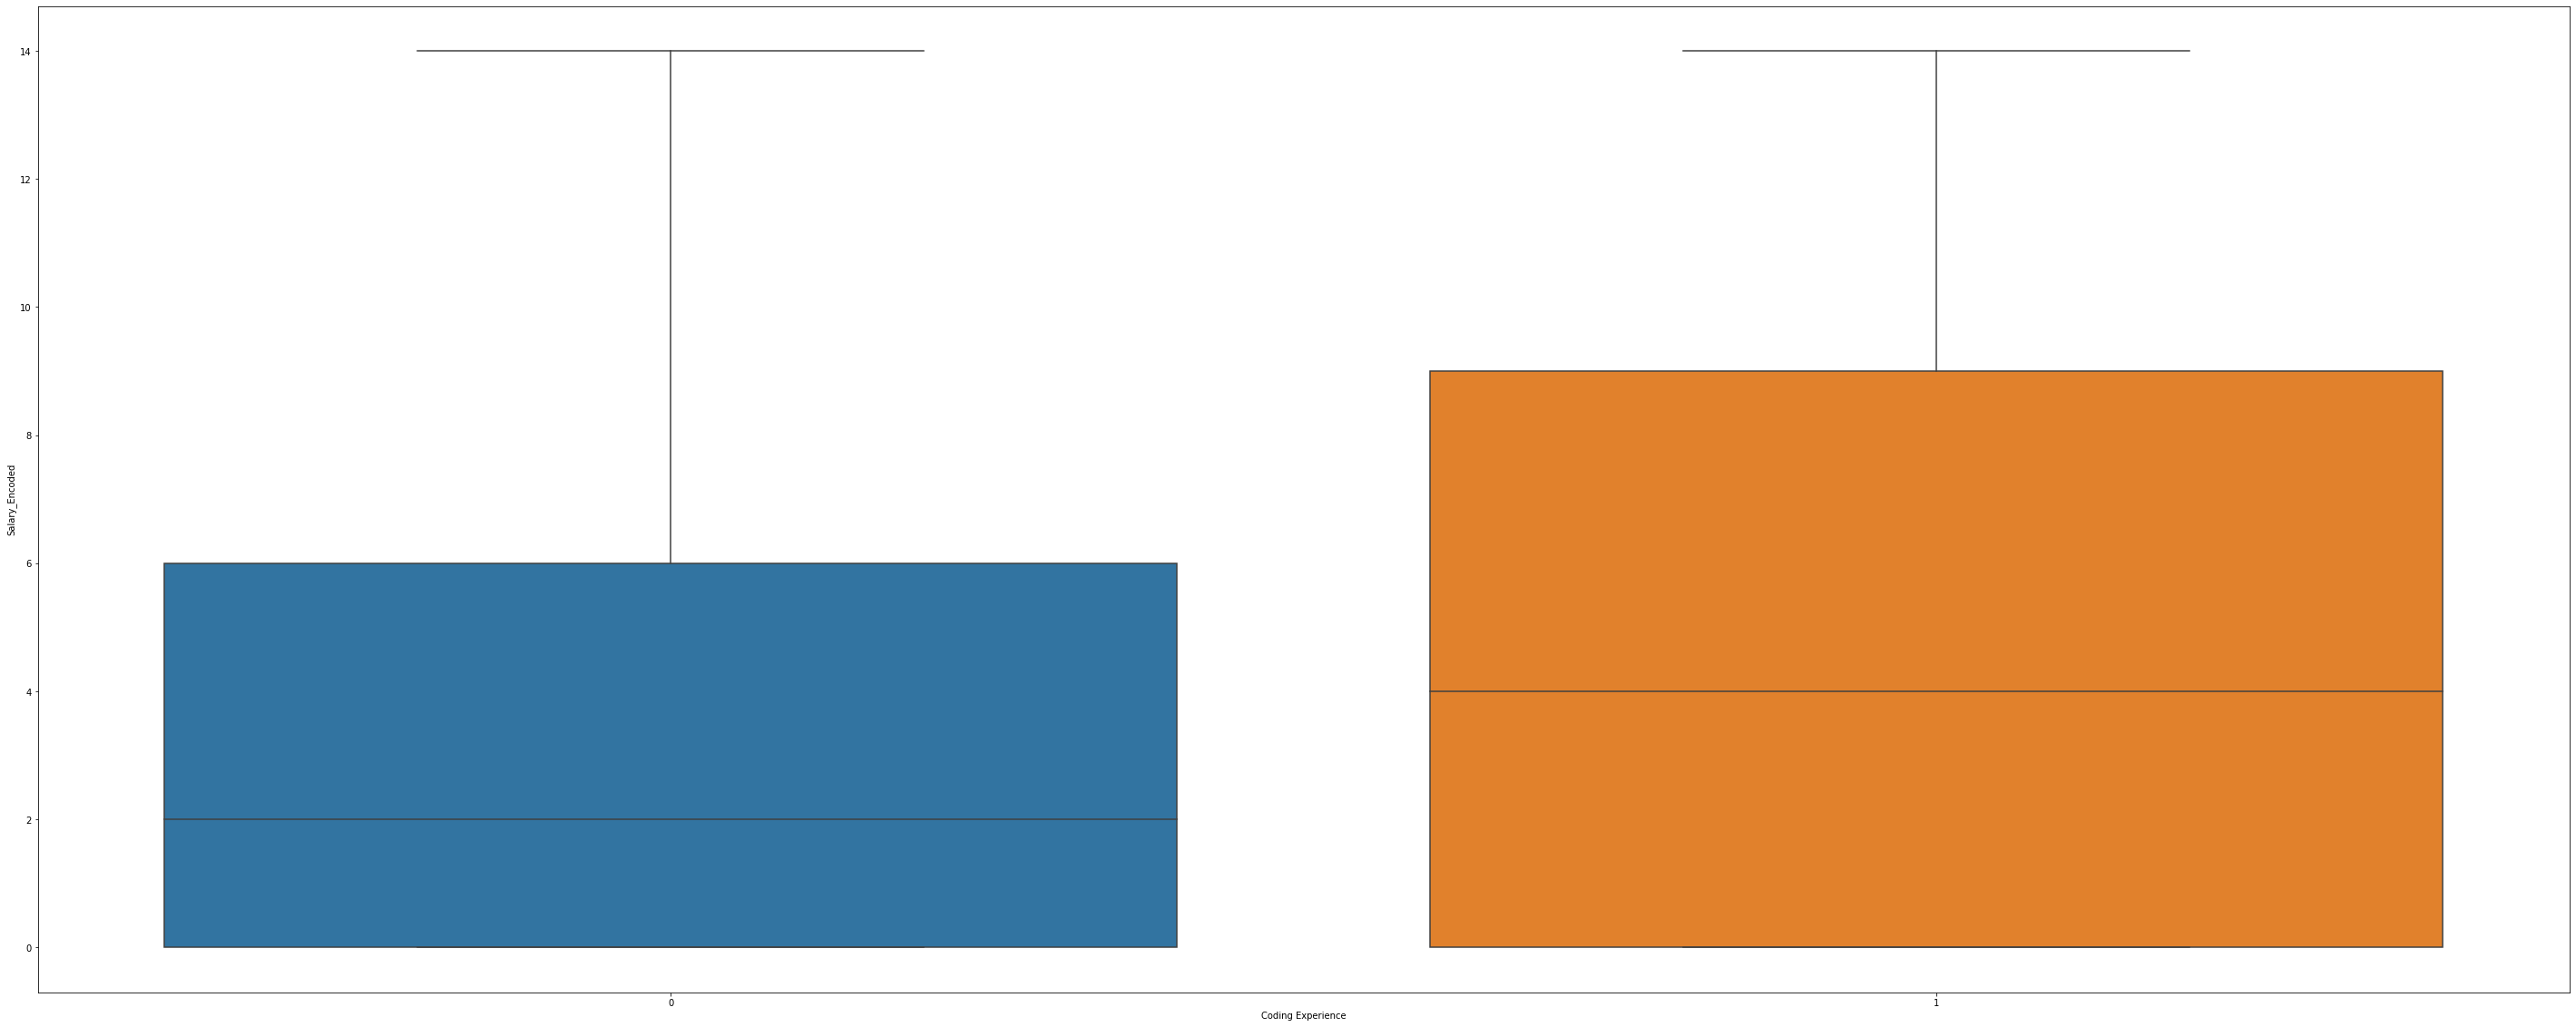

In [70]:
fig = plt.figure(figsize=(50,20))

sns.boxplot(data = df, x='Q31_Encoded', y='Q10_Encoded')
plt.xlabel('Coding Experience')
plt.ylabel('Salary_Encoded')

Text(0, 0.5, 'Salary')

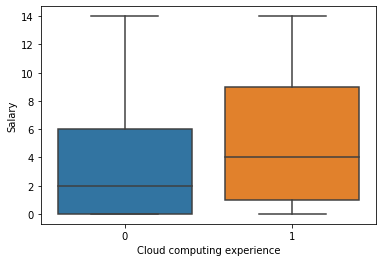

In [73]:
sns.boxplot(data = df, x='Q29_Encoded', y='Q10_Encoded')
plt.xlabel('Cloud computing experience')
plt.ylabel('Salary')

In [74]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q23,Q10_Encoded,Q10_buckets,Q18_Part_1,Q18_Part_2,Q18_Part_3,Q18_Part_4,Q18_Part_5,Q18_Part_6,Q18_Part_7,Q18_Part_8,Q18_Part_9,Q18_Part_10,Q18_Part_11,Q18_Part_12,Q21_Part_1,Q21_Part_2,Q21_Part_3,Q21_Part_4,Q21_Part_5,Q24_Part_1,Q24_Part_2,Q24_Part_3,Q24_Part_4,Q24_Part_5,Q24_Part_6,Q24_Part_7,Q24_Part_8,Q24_Part_9,Q24_Part_10,Q24_Part_11,Q24_Part_12,Q25_Part_1,Q25_Part_2,Q25_Part_3,Q25_Part_4,Q25_Part_5,Q25_Part_6,Q25_Part_7,Q25_Part_8,Q26_Part_1,Q26_Part_2,Q26_Part_3,Q26_Part_4,Q26_Part_5,Q26_Part_6,Q26_Part_7,Q27_Part_1,Q27_Part_2,Q27_Part_3,Q27_Part_4,Q27_Part_5,Q27_Part_6,Q29_Part_1,Q29_Part_2,Q29_Part_3,Q29_Part_4,Q29_Part_5,Q29_Part_6,Q29_Part_7,Q29_Part_8,Q29_Part_9,Q29_Part_10,Q29_Part_11,Q29_Part_12,Q31_Part_1,Q31_Part_2,Q31_Part_3,Q31_Part_4,Q31_Part_5,Q31_Part_6,Q31_Part_7,Q31_Part_8,Q31_Part_9,Q31_Part_10,Q31_Part_11,Q31_Part_12,Q32_Part_1,Q32_Part_2,Q32_Part_3,Q32_Part_4,Q32_Part_5,Q32_Part_6,Q32_Part_7,Q32_Part_8,Q32_Part_9,Q32_Part_10,Q32_Part_11,Q32_Part_12,Q33_Part_1,Q33_Part_2,Q33_Part_3,Q33_Part_4,Q33_Part_5,Q33_Part_6,Q33_Part_7,Q33_Part_8,Q33_Part_9,Q33_Part_10,Q33_Part_11,Q33_Part_12,Q34_Part_1,Q34_Part_2,Q34_Part_3,Q34_Part_4,Q34_Part_5,Q34_Part_6,Q34_Part_7,Q34_Part_8,Q34_Part_9,Q34_Part_10,Q34_Part_11,Q34_Part_12,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q11_Encoded,Q23_Encoded,Q15_Encoded,Q3_continents,Age_Encoded,Q9_Responses,Q18_Encoded,Q21_Encoded,Q24_Encoded,Q25_Encoded,Q26_Encoded,Q27_Encoded,Q29_Encoded,Q31_Encoded,Q32_Encoded,Q33_Encoded,Q34_Encoded
0,510,22-24,Male,-1,France,Master’s degree,IT/Business roles,-1,"1000-9,999 employees",0,No,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",1,1,1,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.0,1.5,1.5,Europe,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
1,423,40-44,Male,-1,India,Professional degree,IT/Business roles,-1,"> 10,000 employees",20+,Yes,"5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1.0,0.5,0.0,India,42,Data Science activity,0,None,Others,0,0,0,0,0,0,0,0
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,No,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",1,1,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0.5,2.5,1.5,Oceania,42,Other,1,GPU,Deep Neural Networks,1,1,0,1,1,1,0,1
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No,"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-9,999",1,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0.5,0.5,India,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
4,470,50-54,Male,-1,France,Master’s degree,Data Engineering roles,-1,0-49 employees,1-4,Yes,"60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,10-15 years,6,"60,000-69,999",1,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0

In [75]:
#Now let's clean up columns that have been engineered & encoded, to keep just those we need
for i in range(12):
    df.drop(columns = ['Q18_Part_%d' %(i+1)], inplace = True)
for i in range(5):
    df.drop(columns = ['Q21_Part_%d' %(i+1)], inplace = True)
for i in range(12):
    df.drop(columns = ['Q24_Part_%d' %(i+1)], inplace = True)
for i in range(8):
    df.drop(columns = ['Q25_Part_%d' %(i+1)], inplace = True)
for i in range(7):
    df.drop(columns = ['Q26_Part_%d' %(i+1)], inplace = True)
for i in range(6):
    df.drop(columns = ['Q27_Part_%d' %(i+1)], inplace = True)
for i in range(12):
    df.drop(columns = ['Q29_Part_%d' %(i+1), 'Q31_Part_%d' %(i+1), 'Q32_Part_%d' %(i+1), 'Q33_Part_%d' %(i+1), 'Q34_Part_%d' %(i+1) ], inplace = True)

In [76]:
df.head()


,Time from Start to Finish (seconds),Q1,Q2,Q2_OTHER_TEXT,Q3,Q4,Q5,Q5_OTHER_TEXT,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q23,Q10_Encoded,Q10_buckets,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q11_Encoded,Q23_Encoded,Q15_Encoded,Q3_continents,Age_Encoded,Q9_Responses,Q18_Encoded,Q21_Encoded,Q24_Encoded,Q25_Encoded,Q26_Encoded,Q27_Encoded,Q29_Encoded,Q31_Encoded,Q32_Encoded,Q33_Encoded,Q34_Encoded
0,510,22-24,Male,-1,France,Master’s degree,IT/Business roles,-1,"1000-9,999 employees",0,No,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",1,0,0,0,0,0.0,1.5,1.5,Europe,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
1,423,40-44,Male,-1,India,Professional degree,IT/Business roles,-1,"> 10,000 employees",20+,Yes,"5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",0,0,0,0,1,1.0,0.5,0.0,India,42,Data Science activity,0,None,Others,0,0,0,0,0,0,0,0
2,391,40-44,Male,-1,Australia,Master’s degree,Other,0,"> 10,000 employees",20+,No,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",0,0,0,1,0,0.5,2.5,1.5,Oceania,42,Other,1,GPU,Deep Neural Networks,1,1,0,1,1,1,0,1
3,392,22-24,Male,-1,India,Bachelor’s degree,Other,1,0-49 employees,0,No,"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-9,999",0,0,0,1,0,0.0,0.5,0.5,India,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
4,470,50-54,Male,-1,France,Master’s degree,Data Engineering roles,-1,0-49 employees,1-4,Yes,"60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,10-15 years,6,"60,000-69,999",0,1,0,0,0,0.5,12.5,25.0,Europe,52,Machine Learning activity,1,GPU,Deep Neural Networks,1,0,1,1,1,1,1,1


In [77]:
df.drop(columns = ['Q2_OTHER_TEXT','Q5_OTHER_TEXT', 'Q3'], inplace = True)

In [78]:
df.head()

,Time from Start to Finish (seconds),Q1,Q2,Q4,Q5,Q6,Q7,Q8,Q10,Q11,Q14,Q15,Q23,Q10_Encoded,Q10_buckets,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,Q11_Encoded,Q23_Encoded,Q15_Encoded,Q3_continents,Age_Encoded,Q9_Responses,Q18_Encoded,Q21_Encoded,Q24_Encoded,Q25_Encoded,Q26_Encoded,Q27_Encoded,Q29_Encoded,Q31_Encoded,Q32_Encoded,Q33_Encoded,Q34_Encoded
0,510,22-24,Male,Master’s degree,IT/Business roles,"1000-9,999 employees",0,No,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",1,0,0,0,0,0.0,1.5,1.5,Europe,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
1,423,40-44,Male,Professional degree,IT/Business roles,"> 10,000 employees",20+,Yes,"5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",0,0,0,0,1,1.0,0.5,0.0,India,42,Data Science activity,0,None,Others,0,0,0,0,0,0,0,0
2,391,40-44,Male,Master’s degree,Other,"> 10,000 employees",20+,No,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",0,0,0,1,0,0.5,2.5,1.5,Oceania,42,Other,1,GPU,Deep Neural Networks,1,1,0,1,1,1,0,1
3,392,22-24,Male,Bachelor’s degree,Other,0-49 employees,0,No,"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-9,999",0,0,0,1,0,0.0,0.5,0.5,India,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
4,470,50-54,Male,Master’s degree,Data Engineering roles,0-49 employees,1-4,Yes,"60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,10-15 years,6,"60,000-69,999",0,1,0,0,0,0.5,12.5,25.0,Europe,52,Machine Learning activity,1,GPU,Deep Neural Networks,1,0,1,1,1,1,1,1


In [79]:
renameDict = {'Time from Start to Finish (seconds)':'Time', 'Q1':'Age', 'Q2':'Gender', 'Q5':'Job Title', 'Q6':'Company Size', 'Q7':'Data Science Team Size', 'Q8':'Employer uses ML methods?', 'Q15':'Coding experience', 'Q23':'ML experience', 'Q11_Encoded':'ML Spend_Encoded', 'Q23_Encoded':'ML experience_Encoded', 'Q15_Encoded':'Coding experience_Encoded', 'Q3_continents':'Location','Q9_Responses':'Role activities', 'Q18_Encoded':'Data Science Programming Language (Y/N)', 'Q21_Encoded':'Hardware Level','Q24_Encoded':'ML algorithm categories', 'Q25_Encoded':'ML automation_Encoded', 'Q26_Encoded':'Computer Vision_Encoded', 'Q27_Encoded':'NLP_Encoded', 'Q29_Encoded':'Cloud Computing Platforms_Encoded', 'Q31_Encoded':'DataAnalytics_Encoded', 'Q32_Encoded':'ML products_Encoded', 'Q33_Encoded':'Automated ML Products_Encoded', 'Q34_Encoded':'RDBMS Products_Encoded'}
df.rename(columns = renameDict, inplace = True)

In [80]:
renameDict = {'Q10':'Salary', 'Q11':'ML Spend', 'Q14':'Primary data analysis tool', 'Q10_buckets':'Salary_buckets'}
df.rename(columns = renameDict, inplace = True)

In [81]:
df.rename(columns = {'Q4':'Education', 'Q10_Encoded':'Salary_encoded'}, inplace = True)

In [82]:
df.head()

,Time,Age,Gender,Education,Job Title,Company Size,Data Science Team Size,Employer uses ML methods?,Salary,ML Spend,Primary data analysis tool,Coding experience,ML experience,Salary_encoded,Salary_buckets,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,ML Spend_Encoded,ML experience_Encoded,Coding experience_Encoded,Location,Age_Encoded,Role activities,Data Science Programming Language (Y/N),Hardware Level,ML algorithm categories,ML automation_Encoded,Computer Vision_Encoded,NLP_Encoded,Cloud Computing Platforms_Encoded,DataAnalytics_Encoded,ML products_Encoded,Automated ML Products_Encoded,RDBMS Products_Encoded
0,510,22-24,Male,Master’s degree,IT/Business roles,"1000-9,999 employees",0,No,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",1,0,0,0,0,0.0,1.5,1.5,Europe,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
1,423,40-44,Male,Professional degree,IT/Business roles,"> 10,000 employees",20+,Yes,"5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",0,0,0,0,1,1.0,0.5,0.0,India,42,Data Science activity,0,None,Others,0,0,0,0,0,0,0,0
2,391,40-44,Male,Master’s degree,Other,"> 10,000 employees",20+,No,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",0,0,0,1,0,0.5,2.5,1.5,Oceania,42,Other,1,GPU,Deep Neural Networks,1,1,0,1,1,1,0,1
3,392,22-24,Male,Bachelor’s degree,Other,0-49 employees,0,No,"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-9,999",0,0,0,1,0,0.0,0.5,0.5,India,23,Other,1,GPU,Basic ML approaches,0,0,0,0,0,0,0,0
4,470,50-54,Male,Master’s degree,Data Engineering roles,0-49 employees,1-4,Yes,"60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,10-15 years,6,"60,000-69,999",0,1,0,0,0,0.5,12.5,25.0,Europe,52,Machine Learning activity,1,GPU,Deep Neural Networks,1,0,1,1,1,1,1,1


### Feature Importance, Selection & Engineering

In [83]:
#Cramer's V code courtesy: Shaked Zychlinski https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [84]:
cdf = df[['Time','Age','Gender','Education','Job Title','Company Size','Data Science Team Size','Employer uses ML methods?','ML Spend','Primary data analysis tool','Coding experience','ML experience','Location','Role activities','Salary_encoded','Data Science Programming Language (Y/N)','Hardware Level','ML algorithm categories','ML automation_Encoded','Computer Vision_Encoded','NLP_Encoded','Cloud Computing Platforms_Encoded','DataAnalytics_Encoded','ML products_Encoded','Automated ML Products_Encoded','RDBMS Products_Encoded']]       

C:\Users\aruns\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


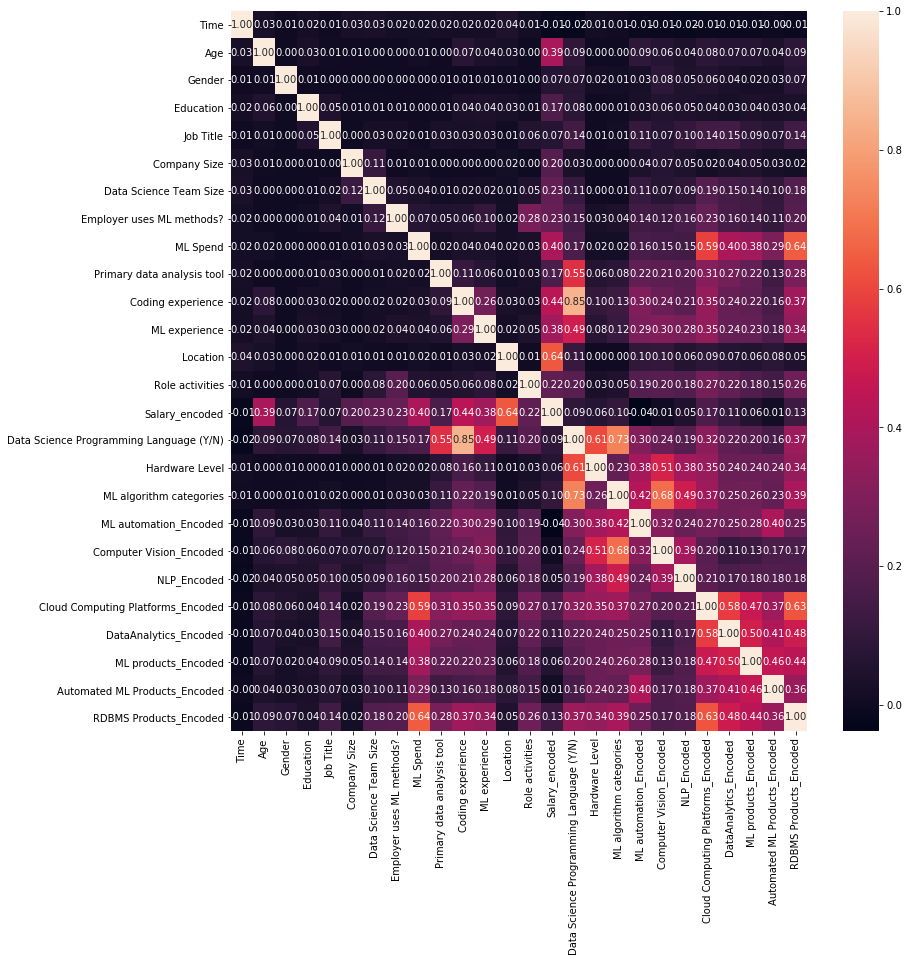

In [85]:
fig = plt.figure(figsize=(5,5))
axis = plt.axes([1,1,2,2])
associations(cdf, theil_u = True, ax = axis)

The Cramers-V heatmap gives us a good idea of association between features. We can see that some features exhibit strong correlation and this can be exploited for feature engineering & reducing complexity. 

1. We see that Data Science Programming Language is strongly correlated (85%) with coding experience and fairly correlated with primary data analysis tool (55%) and ML experience (49%). It is safe to say that this feature is well-represented by these other features,  so we can drop this column. 
2. RDBMS producs are fairly strongly correlated with ML Spend & Cloud computing producs, so we can drop this column as well. 
3. Computer Vision is srongly correlated with ML_algorithm categories & so we can drop his column. 

In [86]:
dropcolumns = ['Data Science Programming Language (Y/N)','RDBMS Products_Encoded','Computer Vision_Encoded']
df.drop(columns = dropcolumns, inplace = True)

There seems to be a strong inter-dependence relationship between the last few features, namely cloud-computing platforms, data anaytics products, ML products. So, it makes sense to leverage this to reduce complexity by adding one feature that combines all of these features together: ML/Analytics technology which will be 1 if any of these products in use and 0 if none of them are in use. We will drop the features after creating this new column. 

In [87]:
df['ML/Analytics Technology_Encoded'] = df['Cloud Computing Platforms_Encoded'] + df['DataAnalytics_Encoded'] + df['ML products_Encoded']

In [88]:
df.drop(columns = ['Cloud Computing Platforms_Encoded','DataAnalytics_Encoded','ML products_Encoded'], inplace = True)

We also note that the use of NLP is better captured by the use of ML algorithm categories feature (49% correlation). So, we can drop this. We also note a very weak correlation between ML automated algorithms  & response. We also need to take into account that use of automated ML algorithms is characterized by our new ML/Analytics feature. So, we can drop. Time taken to fill survey is of no significance to the model, so we drop that too. 

In [89]:
df.drop(columns = ['NLP_Encoded', 'ML automation_Encoded','Time'], inplace = True)

In [90]:
df['Company Size'].unique()

array(['1000-9,999 employees', '> 10,000 employees', '0-49 employees',
       '50-249 employees', '250-999 employees'], dtype=object)

In [91]:
df['Data Science Team Size'].unique()

array(['0', '20+', '1-4', '5-9', '10-20'], dtype=object)

In [92]:
dummies_gender = pd.get_dummies(df['Gender'], prefix = 'Gender', drop_first = True)
dummies_education = pd.get_dummies(df['Education'], prefix = 'Education')
dummies_jobtitle = pd.get_dummies(df['Job Title'], prefix = 'Job Title')
dummies_EmployerusesMLmethods = pd.get_dummies(df['Employer uses ML methods?'], prefix = 'ML methods', drop_first = True)
dummies_Location = pd.get_dummies(df['Location'], prefix = 'Location')
dummies_Roleactivities = pd.get_dummies(df['Role activities'], prefix = 'Role activities')
dummies_HardwareLevel = pd.get_dummies(df['Hardware Level'], prefix = 'Hardware Level')
dummies_MLAlgo = pd.get_dummies(df['ML algorithm categories'], prefix = 'ML algorithm categories')
#Label encoding company size & data science team size
comp_encoder = {'0-49 employees':0.005,'50-249 employees':0.01,'250-999 employees':0.0375, '1000-9,999 employees':0.45,'> 10,000 employees':1 }
dsteam_encoder = {'0':0,'1-4':5,'5-9':5,'10-20':15,'20+':25}
df['Company Size_Encoded']=df['Company Size']
df['Data Science Team Size_Encoded']=df['Data Science Team Size']
df['Company Size_Encoded'].replace(comp_encoder, inplace = True)
df['Data Science Team Size_Encoded'].replace(dsteam_encoder, inplace = True)

In [93]:
df.head()

,Age,Gender,Education,Job Title,Company Size,Data Science Team Size,Employer uses ML methods?,Salary,ML Spend,Primary data analysis tool,Coding experience,ML experience,Salary_encoded,Salary_buckets,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,ML Spend_Encoded,ML experience_Encoded,Coding experience_Encoded,Location,Age_Encoded,Role activities,Hardware Level,ML algorithm categories,Automated ML Products_Encoded,ML/Analytics Technology_Encoded,Company Size_Encoded,Data Science Team Size_Encoded
0,22-24,Male,Master’s degree,IT/Business roles,"1000-9,999 employees",0,No,"30,000-39,999",$0 (USD),"Basic statistical software (Microsoft Excel, G...",1-2 years,1-2 years,3,"30,000-39,999",1,0,0,0,0,0.0,1.5,1.5,Europe,23,Other,GPU,Basic ML approaches,0,0,0.450,0
1,40-44,Male,Professional degree,IT/Business roles,"> 10,000 employees",20+,Yes,"5,000-7,499","> $100,000 ($USD)","Cloud-based data software & APIs (AWS, GCP, Az...",I have never written code,< 1 years,0,"0-9,999",0,0,0,0,1,1.0,0.5,0.0,India,42,Data Science activity,None,Others,0,0,1.000,25
2,40-44,Male,Master’s degree,Other,"> 10,000 employees",20+,No,"250,000-299,999","$10,000-$99,999","Local development environments (RStudio, Jupyt...",1-2 years,2-3 years,14,">250,000",0,0,0,1,0,0.5,2.5,1.5,Oceania,42,Other,GPU,Deep Neural Networks,0,3,1.000,25
3,22-24,Male,Bachelor’s degree,Other,0-49 employees,0,No,"4,000-4,999",$0 (USD),"Local development environments (RStudio, Jupyt...",< 1 years,< 1 years,0,"0-9,999",0,0,0,1,0,0.0,0.5,0.5,India,23,Other,GPU,Basic ML approaches,0,0,0.005,0
4,50-54,Male,Master’s degree,Data Engineering roles,0-49 employees,1-4,Yes,"60,000-69,999","$10,000-$99,999","Advanced statistical software (SPSS, SAS, etc.)",20+ years,10-15 years,6,"60,000-69,999",0,1,0,0,0,0.5,12.5,25.0,Europe,52,Machine Learning activity,GPU,Deep Neural Networks,1,3,0.005,5


In [94]:
df_model = pd.concat([df, dummies_gender, dummies_education, dummies_EmployerusesMLmethods, dummies_Location, dummies_Roleactivities, dummies_HardwareLevel],axis = 1)

In [95]:
df_model.head()
df_model.drop(columns = ['Age', 'Gender', 'Education','Job Title','Company Size','Data Science Team Size', 'Employer uses ML methods?','Salary','ML Spend','Primary data analysis tool','Coding experience','ML experience','Salary_buckets','Location','Role activities','Hardware Level','ML algorithm categories'], inplace = True)

In [96]:
df_model.rename({'Q14_Part_1_TEXT':'Primary data analysis tool_Basic statistical software','Q14_Part_2_TEXT':'Primary data analysis tool_Advanced statistical software','Q14_Part_3_TEXT':'Primary data analysis tool_Business intelligence software','Q14_Part_4_TEXT':'Primary data analysis tool_Local Development Environment','Q14_Part_5_TEXT':'Primary data analysis tool_Cloud-based Software'}, inplace = True)

In [97]:
df_model.head()

,Salary_encoded,Q14_Part_1_TEXT,Q14_Part_2_TEXT,Q14_Part_3_TEXT,Q14_Part_4_TEXT,Q14_Part_5_TEXT,ML Spend_Encoded,ML experience_Encoded,Coding experience_Encoded,Age_Encoded,Automated ML Products_Encoded,ML/Analytics Technology_Encoded,Company Size_Encoded,Data Science Team Size_Encoded,Gender_Male,Gender_Other,Education_Bachelor’s degree,Education_Doctoral degree,Education_Master’s degree,Education_Professional degree,Education_School,ML methods_Yes,Location_Africa,Location_Asia,Location_Europe,Location_India,Location_North America,Location_Oceania,Location_Other,Location_South America,Location_United States of America,Role activities_Data Science activity,Role activities_Machine Learning activity,Role activities_Other,Hardware Level_CPU,Hardware Level_GPU,Hardware Level_None,Hardware Level_TPU
0,3,1,0,0,0,0,0.0,1.5,1.5,23,0,0,0.450,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,1,1.0,0.5,0.0,42,0,0,1.000,25,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0
2,14,0,0,0,1,0,0.5,2.5,1.5,42,0,3,1.000,25,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,1,0,0.0,0.5,0.5,23,0,0,0.005,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0
4,6,0,1,0,0,0,0.5,12.5,25.0,52,1,3,0.005,5,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0


### Implementing Logistic Regression

In [98]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,\
                        train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    
    plt.figure(figsize=(10,6))
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel(scoring)
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,\
                     train_scores_mean + train_scores_std, alpha=0.1, \
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,\
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    
    return plt

In [99]:
X = df_model.drop(['Salary_encoded'],axis=1)
y = df_model['Salary_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=102, test_size=0.3)

In [100]:
X_train.shape

(8747, 37)

In [101]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\aruns\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\aruns\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\aruns\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int32, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [102]:
import warnings
#warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore")

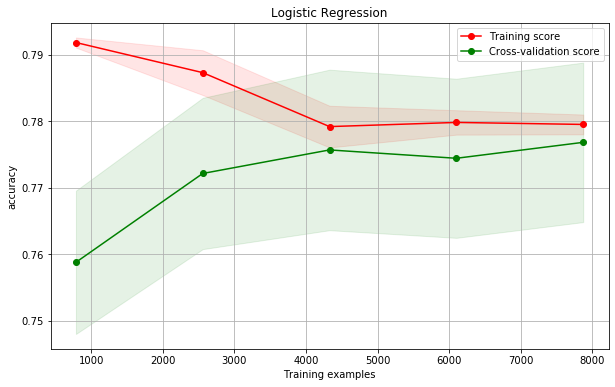

In [103]:
scoreList = [] #List containing probability score at each iteration probList = []
predictedProbabilityDF = pd.DataFrame()

for i in range(14):
# Classify all labels as one or zero depending on the current label value
    y_train_local_List = []
    for index,val in y_train.iteritems():
        if(val <= i):
            y_train_local_List.append(0)
        else:
            y_train_local_List.append(1)
    #This is the response for this iteration with just 1s and 0s
    y_train_local = pd.Series(y_train_local_List)
    #Build & run a model for logistic regression model = LogisticRegression
    model = LogisticRegression()
    model.fit(X_train, y_train_local)
    prob = model.predict_proba(X_train)
    y_predicted = model.predict(X_train)
    predProbForLabel0 = [row[0] for row in prob]
    predictedProbabilityDF['Salary Label %d' %i] = pd.Series(predProbForLabel0)
    scoreList.append(accuracy_score(y_predicted,y_train_local))
    if(i==0):
        plot_learning_curve(model,'Logistic Regression', X_train, y_train_local, cv=10)

In [104]:
for j in range(13):
    predictedProbabilityDF['Salary Label %d' %(j+1)] = predictedProbabilityDF['Salary Label %d' %(j+1)] - predictedProbabilityDF['Salary Label %d' %(j)]
predictedProbabilityDF['Salary Label 14'] = 1 - predictedProbabilityDF['Salary Label 13'] 

In [105]:
predictedProbabilityDF.head()

,Salary Label 0,Salary Label 1,Salary Label 2,Salary Label 3,Salary Label 4,Salary Label 5,Salary Label 6,Salary Label 7,Salary Label 8,Salary Label 9,Salary Label 10,Salary Label 11,Salary Label 12,Salary Label 13,Salary Label 14
0,0.612080,0.144341,0.685481,0.209219,0.713902,0.217665,0.741946,0.218999,0.752200,0.224445,0.757770,0.233542,0.763788,0.234828,0.765172
1,0.028820,0.008172,0.047078,0.021217,0.073452,0.038745,0.114038,0.104435,0.213525,0.203997,0.438100,0.407159,0.538862,0.449103,0.550897
2,0.732025,0.132619,0.789102,0.151719,0.801450,0.163593,0.805165,0.171684,0.806088,0.173334,0.811635,0.170556,0.811611,0.178502,0.821498
3,0.469288,0.250789,0.590389,0.274305,0.630302,0.298887,0.647044,0.316973,0.651665,0.322391,0.660580,0.322244,0.665928,0.326176,0.673824
4,0.014905,0.007263,0.026337,0.014185,0.035436,0.023466,0.068587,0.055005,0.164648,0.145561,0.495319,0.370601,0.565860,0.410065,0.589935


In [106]:
predictions_train = model.predict(X_train)

### Cross Validation
We perform a 10-fold cross validation to determine average accuracy & standard deviation across the training data-set.

In [107]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X)

accuracy = np.zeros(10)
np_idx = 0

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.values[train_idx], X.values[test_idx]
    y_train, y_test = y.values[train_idx], y.values[test_idx]
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    TN = confusion_matrix(y_test, predictions)[0][0]
    FP = confusion_matrix(y_test, predictions)[0][1]
    FN = confusion_matrix(y_test, predictions)[1][0]
    TP = confusion_matrix(y_test, predictions)[1][1]
    total = TN + FP + FN + TP
    ACC = (TP + TN) / float(total)
    
    accuracy[np_idx] = ACC*100
    np_idx += 1
    
    print ("Fold {}: Accuracy: {}%".format(np_idx, round(ACC,3)))   

print ("Average Score: {}%({}%)".format(round(np.mean(accuracy),3),round(np.std(accuracy),3)))

Fold 1: Accuracy: 0.705%
Fold 2: Accuracy: 0.759%
Fold 3: Accuracy: 0.727%
Fold 4: Accuracy: 0.749%
Fold 5: Accuracy: 0.74%
Fold 6: Accuracy: 0.792%
Fold 7: Accuracy: 0.733%
Fold 8: Accuracy: 0.765%
Fold 9: Accuracy: 0.787%
Fold 10: Accuracy: 0.76%
Average Score: 75.186%(2.517%)


We note that the accuracy is fairly high and standard deviation is low, implying a situation of low bias & low variance.

### Hyper Parameter Tuning
We can use the Grid-search method to vary hyper parameter values & determine the optimal value of C and choice of solver.

In [108]:
model = LogisticRegression()
scaler = StandardScaler()
kfold = KFold(n_splits=10)
kfold.get_n_splits(X_train)

best_model = model
best_params = {}
best_accuracy = 0
best_std = 0

for C in [0.001,0.01,0.05,0.1,0.5,1,5,10, 100]:
    for solver in ['newton-cg','lbfgs','liblinear','sag']:
        
        model = LogisticRegression(C=C, solver=solver)
        accuracy = np.zeros(10)
        np_idx = 0
        
        for train_idx, test_idx in kfold.split(X):
            X_train, X_test = X.values[train_idx], X.values[test_idx]
            y_train, y_test = y.values[train_idx], y.values[test_idx]

            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            model.fit(X_train, y_train)

            predictions = model.predict(X_test)

            TN = confusion_matrix(y_test, predictions)[0][0]
            FP = confusion_matrix(y_test, predictions)[0][1]
            FN = confusion_matrix(y_test, predictions)[1][0]
            TP = confusion_matrix(y_test, predictions)[1][1]
            total = TN + FP + FN + TP
            ACC = (TP + TN) / float(total)

            accuracy[np_idx] = ACC*100
            np_idx += 1
        
        if np.mean(accuracy) > best_accuracy:
            best_model = model
            best_params = {'C':C, 'solver':solver}
            best_accuracy = np.mean(accuracy)
            best_std = np.std(accuracy)

print (best_params)
print ("Best Score: {}%({}%)".format(round(best_accuracy,3),round(best_std,3)))      

print ("\nThe optimal log model uses C={}, and a {} solver, and has a cross validation score of {}% with a standard deviation of {}%".format(best_params['C'],best_params['solver'],round(best_accuracy,3),round(best_std,3)))

{'C': 0.05, 'solver': 'newton-cg'}
Best Score: 75.205%(2.443%)

The optimal log model uses C=0.05, and a newton-cg solver, and has a cross validation score of 75.205% with a standard deviation of 2.443%


After performing the Hyper Parameter Tuning, we can see that optimal model uses C of 0.05 & a newton-cg solver. It hsa resulted in an improvement in accuracy of 0.019 percent. 

In [109]:
model = LogisticRegression(C = 0.05, solver = 'newton-cg')
model.fit(X_train, y_train)

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [110]:
predictions_train = model.predict(X_train)

### Model Evaluation

In [111]:
predictions_test = model.predict(X_test)

TN = confusion_matrix(y_test, predictions_test)[0][0]
FP = confusion_matrix(y_test, predictions_test)[0][1]
FN = confusion_matrix(y_test, predictions_test)[1][0]
TP = confusion_matrix(y_test, predictions_test)[1][1]
total = TN + FP + FN + TP
ACC = (TP + TN) / float(total)

print ("This model got an accuracy of {}% on the testing set".format(round(ACC*100,2))) 
Accuracy = round(ACC*100,2)

This model got an accuracy of 75.9% on the testing set


In [112]:
print(classification_report(predictions_test,y_test))

              precision    recall  f1-score   support

           0       0.94      0.48      0.63      1012
           1       0.01      0.10      0.02        20
           2       0.01      0.07      0.02        14
           3       0.05      0.18      0.07        17
           4       0.09      0.12      0.11        41
           5       0.00      0.00      0.00        16
           6       0.03      0.15      0.05        13
           7       0.05      0.33      0.08         6
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.24      0.17      0.20        70
          11       0.11      0.18      0.14        17
          12       0.21      0.25      0.23        16
          13       0.00      0.00      0.00         1
          14       0.00      0.00      0.00         4

   micro avg       0.41      0.41      0.41      1249
   macro avg       0.12      0.14      0.10      1249
weighted avg       0.79   

As an evaluation metric, it makes sense to use precision scores since it gives the proportion of true positives out of all positives. This is a good measure of performance because in this case of binary logistic regression, we are only interested in the classification of whether the given data point is in a particular salary class or not. So, it makes sense to use precision. From the classification report, it can be seen that the data is skewed heavily towards the first <10000 USD class and this can explain the comparative lack of precision for all other classes. It goes to show that we need a well-distributed dataset to accurately make predictions for all classes. 

### Bias-Variance Tradeoff

In [113]:
trainErr = mean_squared_error(y_train, predictions_train)
testErr = mean_squared_error(y_test, predictions_test)
print('The training error is %f' %trainErr)
print('The test error is %f' %testErr)
print('The total error is %f'%(testErr + trainErr))

The training error is 14.214438
The test error is 14.542834
The total error is 28.757272


Text(0.5, 1.0, 'Bias-Variance Tradeoff')

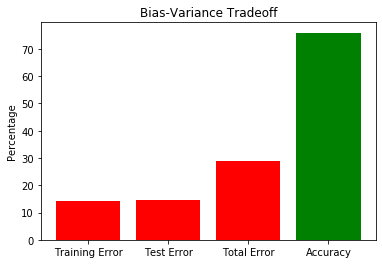

In [114]:
totErr = trainErr + testErr
data = [trainErr, testErr, totErr, Accuracy]
plt.bar(x =['Training Error', 'Test Error', 'Total Error', 'Accuracy'], color = ['r','r','r','g'], height = data)
plt.ylabel('Percentage')
plt.title('Bias-Variance Tradeoff')

From the training error & test error, we see that while the bias and variance are fairly comparable and it can't be said that one dominates the other. Having said that, the model does lean towards under-fitting because the bias is only moderately low compared to the variance, and so there is room for improvement on the bias front. 

In [115]:
predDf = pd.DataFrame()
predDf['predictions_test'] = predictions_test
predDf['y_test'] = y_test

Text(0, 0.5, 'Frequency')

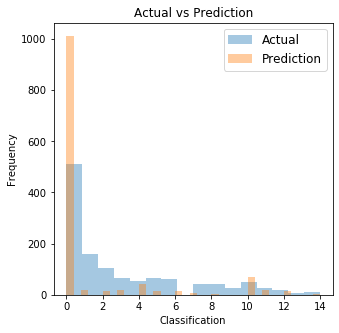

In [116]:
fig = plt.figure(figsize=(5,5))

ax = sns.distplot(predDf['y_test'],  kde=False, label='Actual')
ax = sns.distplot(predDf['predictions_test'],  kde=False,label='Prediction')
plt.legend(prop={'size': 12})
plt.title('Actual vs Prediction')
plt.xlabel('Classification')
plt.ylabel('Frequency')

From this plot, we see that the model has classified many labels in the <10000 USD class. Perhaps, this is due to the skewness present in the test data. 